# Lyrix
## Semester project - Report
<b> Olivier Couque & Emma Lejal Glaude <br>
Supervisor: Panayotis Smeros, Lab: LSIR </b><br>

The goal of this project is to merge lyrics from two different music genres. <br>
Table of content:
1. [Data Gathering](#data)
2. [Data Cleaning](#cleaning)
3. [Preprocessing](#process)
4. [MUSE](#muse)
5. [Neural Network](#nn)
6. [Webpage](#site)

<a id="top"></a>

### Litterature

Regarding this project we had the following sources:
- https://github.com/robbiebarrat/rapping-neural-network
- http://www.encore.ai
- https://github.com/tonybeltramelli/Deep-Lyrics
- https://raplyrics.eu

[Go to top](#top)

<a id="data"></a>

In [47]:
#Usefull imports
import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
import time
import re
import pickle
import requests
from bs4 import BeautifulSoup
import string
import sys
import codecs
import json
import spacy

## Data Gathering

To gather data we had multiple difficulties. First of all we need entire lyrics and not only the bag of words contained in the lyrics. However this is difficult to get as the lyrics are protected by Intellectual Property. Consequently there are no open database with entire lyrics available. On top of this, we need the lyrics classified according with the different musical genres. <br>
We started to look for datasets and encountered the One Million Song Dataset, unfortunately, this dataset contains only the bag of words. Afterwards we considered the MusicBrainz dataset but realized we could only get about a third of the lyrics per song. <br>
We turned to the Kaggle website to look for datasets and found the following ones :
- https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

In [2]:
filepath = "kaggle_lyrics.csv" #lyrics
lyrics_df = pd.read_csv(filepath)
lyrics_df.set_index('index', inplace = True)

In [3]:
print("Number of songs: {}".format(len(lyrics_df)))
lyrics_df.head()

Number of songs: 362237


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [4]:
lyrics_df.dropna(axis = 'index', subset = ['lyrics'], inplace = True)
print("Number of songs WITH available lyrics: {}".format(len(lyrics_df)))

Number of songs WITH available lyrics: 266557


In [5]:
artists = set(lyrics_df["artist"])
genres = set(lyrics_df["genre"])

In [6]:
print("Genres: {}".format(genres))
print("Number of artists: {}".format(len(artists)))

Genres: {'Rock', 'R&B', 'Indie', 'Jazz', 'Pop', 'Folk', 'Other', 'Electronic', 'Metal', 'Country', 'Hip-Hop', 'Not Available'}
Number of artists: 14543


In [7]:
songs_per_genre = {}
total_songs = 0
unknown_songs = 0
for genre in genres:
    nb = len(lyrics_df[lyrics_df['genre'] == genre])
    songs_per_genre[genre] = nb
    total_songs += nb
    if genre == "Not Available" or genre == "Other":
        unknown_songs += nb
songs_per_genre

{'Country': 14387,
 'Electronic': 7966,
 'Folk': 2243,
 'Hip-Hop': 24850,
 'Indie': 3149,
 'Jazz': 7971,
 'Metal': 23759,
 'Not Available': 23941,
 'Other': 5189,
 'Pop': 40466,
 'R&B': 3401,
 'Rock': 109235}

In [8]:
unknown_songs/total_songs

0.10928244240443882

In [9]:
total_songs

266557

Use the detect library to detect the main language of each song and remove the songs that are detected as NOT english

In [ ]:
def language_of_lyrics(lyrics):
    try:
        lang = detect(lyrics)
        return lang
    except:
        return "no lang"

#lyrics_df['language'] = lyrics_df.apply(lambda row: language_of_lyrics, axis = 1)
list_langs = []
for i, row in lyrics_df.iterrows():
    if i % 1000 == 0:
        print(i)
    lang = language_of_lyrics(row['lyrics'])
    list_langs.append(lang)

In [ ]:
lyrics_df['language'] = list_langs

In [ ]:
lyrics_df.to_csv("kaggle_lyrics_with_lang.csv")

In [11]:
lyrics_df = pd.read_csv("kaggle_lyrics_with_lang.csv")

FileNotFoundError: File b'kaggle_lyrics_with_lang.csv' does not exist

In [ ]:
english_df = lyrics_df[lyrics_df['language'] == 'en']
print(len(english_df))
english_df.head()

We will have a look at the distribution of the lyrics that we have. First we need to identify the main genre per artist. To do this we will use the Spotify API.

In [13]:
import spotipy
import spotipy.oauth2 as oauth2
import spotipy.util as util

In [15]:
client_id = "c829ff34022d4c3a9e65c30c10623765"
client_secret = "8e998357ebf04fe092edab4915946e00"

credentials = oauth2.SpotifyClientCredentials(client_id, client_secret)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [16]:
filepath = "mb_music.csv" #we use a file from MusicBrainz to gather artists names
lyrics_df = pd.read_csv(filepath)
useful_df = lyrics_df[['artist.name', 'terms']]
useful_df.head()

,artist.name,terms
0,Casual,hip hop
1,The Box Tops,blue-eyed soul
2,Sonora Santanera,salsa
3,Adam Ant,pop rock
4,Gob,pop punk


In [18]:
with open ('en_artists_from_musicbrainz', 'rb') as fp:
    english_artist = pickle.load(fp)

In [19]:
len(english_artist)

365691

In [20]:
def get_artist_genres(artist_name):
    """ Fetch on Spotify the genres of the artist"""
    query = sp.search(q='artist:' + artist_name, type='artist')
    if len(query['artists']['items']) > 0:
        genres = query['artists']['items'][0]['genres'] # list: ["pop rock", "hard rock", "alternative rock"...]
        return genres
    else:
        #print("{} not on Spotify".format(artist_name))
        return []

In [21]:
def refresh_token():
    token = credentials.get_access_token()
    sp = spotipy.Spotify(auth=token)

In [ ]:
artist_genre = []
artists = english_artist
artists_with_error = []

start = time.time()
print("Initial number of artists: {}".format(len(artists)))
for i, artist in enumerate(artists):
    if i % 500 == 0:
        print(i)
    if (time.time() - start)>= 3600:
        start = time.time()
        refresh_token()
    try:
        genres = get_artist_genres(artist)
        if len(genres) > 0:
            artist_genre.append([artist, genres])
    except :
        artists_with_error.append(artist)
        #print("error for artist : ", artist)
print("Number of artists with genres on Spotify: {}".format(len(artist_genre)))

In [ ]:
artist_genres_df = pd.DataFrame(artist_genre, columns = {'artist', 'genre'})
artist_genres_df = artist_genres_df.drop_duplicates('artist')
artist_genres_df.to_csv("artist_genre.csv", sep=';')

In [22]:
MAIN_GENRES = {'indie', 'metal', 'electronic', 'hip hop', 'country', 'jazz', 'pop', 'rock'}

artist_path = "artist_genre.csv"
artist_genres_df = pd.read_csv(artist_path, sep = ';', usecols = ["artist", "genre"])
artist_genres_df.head() # The genre field is a string and not a list

,artist,genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,Jimmy Hughes,['southern soul']
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


In [23]:
def get_main_genre(genres, main_genres = MAIN_GENRES):
    """ Count occurences of main genres terms in the genres string"""
    main_genres_occ = [(g, len(re.findall(g, genres))) for g in main_genres if len(re.findall(g, genres)) > 0] # list: [(rock, 3), (pop, 1), (hard, 1)...]
    
    if len(main_genres_occ) > 0:
        max_genre = sorted(main_genres_occ, key = lambda x: x[1], reverse = True)[0][0]
        return max_genre
    else:
        return "No main genre"

In [ ]:
simple_genres = []
for i, artist_row in artist_genres_df.iterrows():
    genres = artist_row['genre']
    main_genre = get_main_genre(genres)
    simple_genres.append(main_genre)

col_name = "main genre"
if col_name in list(artist_genres_df.columns):
    artist_genres_df.drop(col_name, inplace = True)
artist_genres_df[col_name] = simple_genres
artist_genres_df.head()

In [ ]:
# Save the dataframe with main genre in a csv file
useful_df = genres_df[["artist", "main genre"]]
useful_df.to_csv("artists_main_genre.csv", index = False)

In [25]:
artist_genres_df = pd.read_csv("artists_main_genre.csv")

Number of artists: 1796
Number of artists with main genre: 1796
Ratio: 1.0


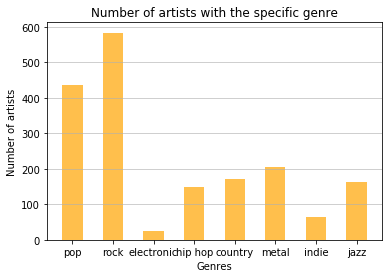

In [26]:
print("Number of artists: {}".format(len(artist_genres_df)))
genres_df = artist_genres_df[artist_genres_df["main genre"] != "No main genre"]
print("Number of artists with main genre: {}".format(len(genres_df)))
print("Ratio: {}".format(len(genres_df) / len(artist_genres_df)))

n, bins, patches = plt.hist(x = list(genres_df["main genre"]), bins=np.arange(0,len(MAIN_GENRES) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.show()

We can see that we have enough songs for the rock genre. We will try to complete this dataset with other songs.

In [27]:
english_df = pd.read_csv("lyrics_cleaned.csv")
artist_genre_df = pd.read_csv("artists_main_genre.csv")
artist_genre_df.head()

,artist,main genre
0,Black Eyed Peas,pop
1,Joy Division,rock
2,Mint Condition,pop
3,Plump DJs,electronic
4,Jope Ruonansuu,pop


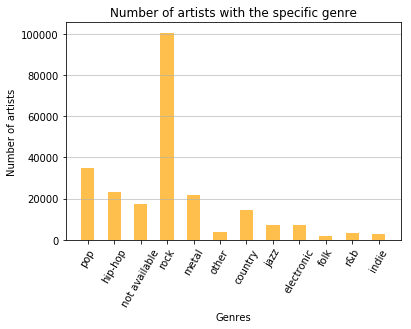

In [28]:
n, bins, patches = plt.hist(x = list(english_df["genre"]), bins=np.arange(0,len(set(english_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.xticks(rotation=60)
plt.show()

In [29]:
main_lyrics_df = english_df[english_df['genre'].isin(MAIN_GENRES)]
print("Ratio of lyrics kept from main genres: {}".format(len(main_lyrics_df) / len(english_df)))

# Give same format of artist names in both dataframes:
main_lyrics_df['artist'] = main_lyrics_df['artist'].apply(lambda a: a.replace('-', ' ').lower()) # beyonce-knowles -> beyonce knowles
artist_genre_df['artist'] = artist_genre_df['artist'].apply(lambda a: a.replace('-', ' ').lower())
# Create dictionary of artist - genre
artist_genre_dict = dict(zip(list(artist_genre_df['artist']), list(artist_genre_df['main genre'])))

# Get the set of artists for which we don't already have the lyrics
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Artists to fetch number: {} , ratio: {}".format(len(artists_to_fetch), len(artists_to_fetch) / len(set(artist_genre_df['artist']))))

Ratio of lyrics kept from main genres: 0.7912138650682717
Artists to fetch number: 1461 , ratio: 0.81438127090301


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We will try to scrap a first website (https://www.lyricsfreak.com) to complete the lyrics.

In [31]:
url_lyricsfreak = 'https://www.lyricsfreak.com'

In [32]:
def get_lyrics_from_link(url):
    response = requests.get(url).content
    soup_lyrics = BeautifulSoup(response, "lxml")
    # Get lyrics from the link
    lyrics_html = soup_lyrics.find_all('div', class_= "dn") # found by inspecting the url
    try:
        lyrics = str(lyrics_html).split('content_h">')[1].split('</div>')[0]
    except IndexError:
        # Some lyrics have an url but acces is restricted
        print("Lyrics restricted for URL {}".format(url))
        return ''
    """Do all the cleaning on the lyrics here: maybe keep if only english ?"""
    # Replace line jump (<br/>) with puctuation .
    lyrics_cleaned = lyrics.replace('<br/>', '. ')
    return lyrics_cleaned


# Given an artist name, get all his songs and lyrics available on lyricsfreak
def get_songs_from_artist(artist_name, genre):
    # Convert artist name to right format for the url
    artist = artist_name.lower()
    first_char = artist[0]
    artist_url = artist.replace(' ', '+') # Name with spaces
    url = url_lyricsfreak + '/' + first_char + '/' + artist_url + '/'
    # Get HTML info on URL
    response = requests.get(url).content
    soup = BeautifulSoup(response, "lxml")
    # Get all songs from that artist on the website
    songs_html = soup.find_all("td", "colfirst") # parameters found by inspecting the url
    
    songs_name_link = []
    for song in songs_html:
        song = str(song)
        if artist_url + '/' in song:
            link = song.split(artist_url + '/')[1].split('"')[0]
            song_name = song.split('title="')[1].split(' Lyrics"')[0]
            # Fetch the lyrics for this song
            url_lyrics = url + link
            lyrics = get_lyrics_from_link(url_lyrics)
            if lyrics != '':
                # Get same format as the rows of the main_lyrics_df
                year = None
                language = None
                songs_name_link.append([song_name, year, artist_name, genre, lyrics, language])
    return songs_name_link

In [33]:
test_artists = ['Northlane', 'Mac Miller']
test_dict = {test_artists[0]: 'metal', test_artists[1]: 'hip hop'}
lyrics_test = []

# Create empty dataframe to store results
df = pd.DataFrame(columns = list(main_lyrics_df.columns))
for artist in test_artists:
    genre = test_dict[artist]
    artist_lyrics = get_songs_from_artist(artist, genre)
    print("{} - Number of lyrics found: {}".format(artist, len(artist_lyrics)))
    lyrics_test.append(artist_lyrics)

Northlane - Number of lyrics found: 0
Mac Miller - Number of lyrics found: 0


In [34]:
songs_per_genre = {}
genres = [g.lower() for g in genres]
for genre in genres:
    if genre == "hip-hop":
        songs_per_genre["hip hop"] = len(english_df[english_df["genre"] == genre])
    else :
        songs_per_genre[genre] = len(english_df[english_df["genre"] == genre])
print(songs_per_genre)
print(MAIN_GENRES)

{'hip hop': 23035, 'indie': 2975, 'metal': 21532, 'electronic': 7016, 'r&b': 3348, 'rock': 100565, 'not available': 17579, 'country': 14252, 'pop': 34807, 'jazz': 7351, 'folk': 1790, 'other': 3989}
{'hip hop', 'indie', 'metal', 'rock', 'country', 'electronic', 'pop', 'jazz'}


In [36]:
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Total length of artists to fetch: {}".format(len(artists_to_fetch)))

genres_to_fetch = ["metal", "jazz", "country","hip hop", "pop"]

artists_to_fetch = [a for a in artists_to_fetch if artist_genre_dict[a] in genres_to_fetch]
print("Length of artists to fetch : {}".format(len(artists_to_fetch)))

Total length of artists to fetch: 1461
Length of artists to fetch : 938


Let's fetch all the songs for all the artists for which we don't have their lyrics in the english_df dataframe. In order to get approximately the same number of songs for each genre, we will set a threshold (e.g. 50'000 songs). Once we have fetched online this threshold from a particular genre we make sure not to fetch any more songs from following artists of this genre

In [ ]:
songs_per_genre_copy = songs_per_genre.copy()
THRESHOLD = 50000
# Create empty dataframe to store results
new_lyrics_df = pd.DataFrame(columns = list(main_lyrics_df.columns))

for i, artist in enumerate(artists_to_fetch):
    if i % 20 == 19:
        print("Percentage Completion: {}% , Lyrics Obtained: {}".format(100*i / len(list(artists_to_fetch)), len(new_lyrics_df)))
        secs_sleep = 60
        print("Now sleeping {} seconds".format(secs_sleep))
        time.sleep(secs_sleep)
    genre = artist_genre_dict[artist]
    nbr_songs_of_genre = songs_per_genre_copy[genre]
    if nbr_songs_of_genre < THRESHOLD:
        artist_lyrics = get_songs_from_artist(artist, genre)
        if len(artist_lyrics) == 0:
            print("Artist {} not found on lyricsfreak".format(artist))
        else:
            list_to_df = pd.DataFrame(artist_lyrics, columns = list(main_lyrics_df.columns))
            new_lyrics_df = new_lyrics_df.append(list_to_df)
            songs_per_genre_copy[genre] += len(artist_lyrics)

In [ ]:
new_lyrics_df.to_csv("kaggleDataset/lyrics_augmented.csv", index = False)

We will now try to scrap another website, which is providing the genre classification: https://www.lyrics.com

In [37]:
url = 'https://www.lyrics.com/genres.php?genre='
genres = ['Pop', 'Hip%20Hop','Folk,%20World,%20__%20Country', 'Jazz', 'Rock']

In [38]:
def get_artist(div):
    return div.find_all('p', class_ = "lyric-meta-album-artist")[0].getText()

In [39]:
def get_lyrics_from_url(lyrics_url):
    r = requests.get('https://www.lyrics.com/' + lyrics_url).content
    soup = BeautifulSoup(r, "lxml")
    try : 
        l = soup.find_all('pre')[0].getText()
    except : 
        l = 'NaN'
    return l

In [40]:
def get_title_url(div):
    data = div.find_all('p', class_= "lyric-meta-title")[0]
    lyrics_url = data.find_all('a', href = True)[0]['href']
    title = data.getText()
    return title, lyrics_url

In [41]:
def get_artist_from_page(df, genre, nb):
    page_url = url + genre + '&p=' + str(nb)
    resp = requests.get(page_url).content
    soup = BeautifulSoup(resp, "lxml")
    content = soup.find_all('div', class_= "lyric-meta col-sm-6 col-xs-6")
    for c in content:
        t, l = get_title_url(c)
        df.loc[len(df)] = [t, get_artist(c), genre, l]
    return df

In [ ]:
MIN_PAGES = 3000
MAX_PAGES = 4681
lyrics_com_df = pd.DataFrame(columns=['title','artist', 'genre', 'lyrics_url'])

In [ ]:
for genre in genres:
    for page in range(MIN_PAGES, MAX_PAGES):
        try :
            get_artist_from_page(lyrics_com_df, genre, page)
            print('finished genre : ', genre, ' page : ', page)
        except :
            time.sleep(10)
            get_artist_from_page(lyrics_com_df, genre, page)

In [ ]:
lyrics_com_df = lyrics_com_df.drop_duplicates('title')
lyrics_com_df.head()

In [ ]:
def get_lyrics(lyrics_com_url):
    l = ''
    while l == '':
        try:
            l = get_lyrics_from_url(lyrics_com_url)
        except:
            print("Slept for : ", lyrics_com_url)
            time.sleep(5)
            continue
    return l

In [ ]:
lyrics_com_df['lyrics'] = lyrics_com_df['lyrics_url'].map(lambda x : get_lyrics(x))

In [ ]:
lyrics_com_df = lyrics_com_df.dropna(axis = 1)
lyrics_com_df = lyrics_com_df.drop_duplicates('lyrics')  
lyrics_com_df.head(10)

In [ ]:
genre_dict = {'Pop': 'pop', 'Hip%20Hop' : 'hip hop','Folk,%20World,%20__%20Country': 'country', 'Jazz':'jazz', 'Rock':'rock'}

In [ ]:
new_lyrics_df = lyrics_com_df.drop('lyrics_url', axis = 1)
new_lyrics_df['genre'] = new_lyrics_df['genre'].map(lambda x : genre_dict[x])
new_lyrics_df.to_csv("lyrics_com.csv", index = False)

Merge all the different files gathered

In [ ]:
final_df = pd.concat([oli_df, pd.read_csv(emma_files[0]), pd.read_csv(emma_files[1]), 
                      pd.read_csv(emma_files[2]), pd.read_csv(emma_files[3]),
                      pd.read_csv(emma_files[4]),pd.read_csv(emma_files[5]),pd.read_csv(emma_files[6]),
                     pd.read_csv('lyrics_jazz.csv'), pd.read_csv('lyrics_metal.csv')], ignore_index=True)

In [ ]:
final_df = final_df.drop_duplicates()
final_df = final_df.dropna(subset = ['lyrics'])

In [ ]:
def adapt_genre(x):
    if x == 'hip-hop':
        return 'hip hop'
    elif x =='folk':
        return 'country'
    else:
        return x

final_df['genre'] = final_df['genre'].map(lambda x: adapt_genre(x))

In [ ]:
final_df['genre'].value_counts()

In [ ]:
def clean_name(x):
    try:
        return x.lower().replace(' ', '-')
    except:
        return x

In [ ]:
final_df['title'] = final_df['title'].map(lambda x : clean_name(x))
final_df['artist'] = final_df['artist'].map(lambda x : clean_name(x))

In [ ]:
final_df['lang'] = final_df['lyrics'].map(lambda l : language_of_lyrics(l))

In [ ]:
en_df = final_df[final_df['lang'] == 'en']
en_df = en_df.drop(['lang'], axis = 1)
print(len(en_df))
en_df.head()

In [ ]:
en_df.to_csv("full_en_lyrics.csv", index= False) # LYRICS FINAL du 7 novembre ??

[Go to top](#top)

<a id="cleaning"></a>

## Data Cleaning

In [42]:
filepath = "lyrics_final.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.drop(['language'], axis = 1)
print(len(lyrics_df))
lyrics_df.head()

317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,"Oh baby, how you doing?\r\r\r\r\r\nYou know I'...",ego-remix,2009.0
1,beyonce-knowles,pop,"playin' everything so easy,\r\r\r\r\r\nit's li...",then-tell-me,2009.0
2,beyonce-knowles,pop,If you search\r\r\r\r\r\nFor tenderness\r\r\r\...,honesty,2009.0
3,beyonce-knowles,pop,"Oh oh oh I, oh oh oh I\r\r\r\r\r\n[Verse 1:]\r...",you-are-my-rock,2009.0
4,beyonce-knowles,pop,"Party the people, the people the party it's po...",black-culture,2009.0


--> Remove [...], {...} and (....) and x(digit)

This information gives structure for the singer but not usefull for lyrics. This is [Chorus], choir in parentheses, x2 etc. <br>
To test regex expressions : https://regex101.com

In [44]:
regex_bracket = re.compile("\[(.*?)\]")
regex_parentheses = re.compile("\((.*?)\)")
regex_curly_bracket = re.compile("\{(.*?)\}")
regex_timesx = re.compile("x[0-9]")

def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                if c.isupper():
                    idx = i
        if idx != -1:
            words[j] = w[:idx] + ' ' + w[idx:]
    return ' '.join(words)


def clean_structure_words(l):
    res= regex_bracket.sub('', l)
    res = regex_parentheses.sub('', res)
    res = regex_curly_bracket.sub('', res)
    res = regex_timesx.sub('', res)
    res = split_words_with_upper(res)
    res = res.lower()
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_structure_words(x))
lyrics_df.tail()

--> Remove . , ! ? ... ---
- We want to keep the * as this represents some swear words in english
- We want to keep the ' as this is part of many words in english, especially when words are cropped, ie 'Cause 
- Otherwise punctuation is not meaningful

In [ ]:
chars_to_keep = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ* \n"

def clean_punctuation(l):
    #res = regex_punct.sub('', l)
    res = re.sub(' +', ' ', l)#res)
    res = res.replace("'", ' ') # replace the quotes with a space.
    res = ''.join(char for char in res if char in chars_to_keep)
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_punctuation(x))
lyrics_df.tail()

[Go to top](#top)

<a id="process"></a>

## Data Preprocessing

Create FastText vectors : https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [ ]:
# First create a txt file with the lyrics
f = open("lyrics.txt", "w+")
for i, r in lyrics_df.iterrows():
    f.write(r['lyrics'])
    
f.close()

In [ ]:
# Generate embeddings
! ./fasttext skipgram -input lyrics.txt -output model_full_lyrics

In [ ]:
file_vec = 'model_lyrics3.vec'
file_bin = 'model_lyrics3.bin'

In [ ]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [ ]:
word_embeddings, vocabulary = load_embeddings(file_vec)
vocabulary = list(vocabulary)

In [ ]:
#If necessary
def get_embedding_for_missing_word(w, file_bin = file_bin):
    #data = ! echo $w | ./fasttext print-word-vectors model_lyrics.bin #emma
    data = ! echo $w | ./fasttext print-word-vectors $file_bin #oli
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

In [ ]:
get_embedding_for_missing_word("we re")

--> Create column with indicator of last word of line

In [48]:
def generate_embedding_for_lyrics(l):
    sentences = l.split('\n')
    embedding = []
    for s in sentences:
        words = s.split(' ')
        for i, w in enumerate(words):
            if len(w)>0:
                try : 
                    idx = vocabulary.index(w)
                    vector = word_embeddings[idx]
                except ValueError : 
                    #print("Word not found :", repr(w))
                    vector = get_embedding_for_missing_word(w)
                if i == (len(words)-1) :
                    vector = np.append(vector, 1)
                else :
                    vector = np.append(vector, 0)
                vector = np.append(w, vector)
                embedding.append(vector)
                
    return embedding

In [ ]:
generate_embedding_for_lyrics("oh baby how you doing\nyou know im gonna cut right to the chase")

--> Create column with type of word (noum, verb, etc)

In [ ]:
en_nlp = spacy.load('en')

ADJ: adjective ADP: adposition ADV: adverb AUX: auxiliary verb CONJ: coordinating conjunction DET: determiner INTJ: interjection NOUN: noun NUM: numeral PART: particle PRON: pronoun PROPN: proper noun PUNCT: punctuation SCONJ: subordinating conjunction SYM: symbol VERB: verb X: other

In [49]:
def generate_pos_for_lyrics(l):
    doc = en_nlp(l)
    embedding = []
    for i in range(len(doc)):
        print(doc[i], doc[i].pos_)
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART':
            embedding.append(type_)
    return embedding

In [50]:
def generate_pos_for_word(w):
    doc = en_nlp(w)
    return doc[0].pos_

In [51]:
pos_to_idx = {'ADJ': 0, 'ADP': 1, 'ADV':2,'AUX': 3,'CONJ': 4,'CCONJ': 5,'DET': 6, 'INTJ': 7, 'NOUN': 8,
              'NUM': 9, 'PART': 10,'PRON':11, 'PROPN': 12, 'PUNCT': 13, 'SCONJ': 14, 'SYM': 15, 
              'VERB': 16, 'X': 17}

In [ ]:
def merge_embedding_pos(l):
    embedding = generate_embedding_for_lyrics(l)
    for i in range(len(embedding)):
        w = embedding[i][0]
        if w != '\n':
            pos = generate_pos_for_word(str(w))
            bin_vector = np.zeros(18)
            bin_vector[pos_to_idx[pos]] = 1
            embedding[i] = np.append(embedding[i], bin_vector)
    return embedding

--> Create column with Entity Recognition

In [ ]:
nlp = spacy.load('en_core_web_sm')

Entity types : <br>
PERSON	People, including fictional.<br>
NORP	Nationalities or religious or political groups.<br>
FAC	Buildings, airports, highways, bridges, etc.<br>
ORG	Companies, agencies, institutions, etc.<br>
GPE	Countries, cities, states.<br>
LOC	Non-GPE locations, mountain ranges, bodies of water.<br>
PRODUCT	Objects, vehicles, foods, etc. (Not services.)<br>
EVENT	Named hurricanes, battles, wars, sports events, etc.<br>
WORK_OF_ART	Titles of books, songs, etc.<br>
LAW	Named documents made into laws.<br>
LANGUAGE	Any named language.<br>
DATE	Absolute or relative dates or periods.<br>
TIME	Times smaller than a day.<br>
PERCENT	Percentage, including "%".<br>
MONEY	Monetary values, including unit.<br>
QUANTITY	Measurements, as of weight or distance.<br>
ORDINAL	"first", "second", etc.<br>
CARDINAL	Numerals that do not fall under another type.<br>

In [ ]:
doc = nlp(lyrics_df.loc[24]['lyrics'].replace('\n', '').lower())
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

In [ ]:
def get_entity_for_lyrics(l):
    l = l.replace('\n', ' ').lower()
    doc = nlp(l)
    l_list = l.split(' ')
    curr_i = 0
    result = np.empty(shape=len(l_list), dtype=object)
    for ent in doc.ents:
        if ent.text.replace(' ', '') != '':
            ent_list = ent.text.split(' ')
            try:
                s, e = find_sub_list(ent_list, l_list[curr_i:])
                s += curr_i
                e += curr_i
                for i in range(s, e+1):
                    result[i] = ent.label_
                curr_i = e
            except : 
                print(ent_list)
                print(l_list[curr_i:])
    return result

In [ ]:
ent_to_idx = {'PERSON' : 0,
'NORP': 1,
'FAC' : 2,
'ORG' : 3,
'GPE' : 4,
'LOC' : 5,
'PRODUCT' : 6,
'EVENT' : 7,
'WORK_OF_ART' : 8,
'LAW': 9,
'LANGUAGE' : 10,
'DATE' : 11,
'TIME' : 12,
'PERCENT' : 13,
'MONEY' : 14,
'QUANTITY' : 15,
'ORDINAL' : 16,
'CARDINAL': 17}

In [ ]:
def add_ent_to_embedding(emb, l):
    # Compute the entities for the lyrics
    ents = get_entity_for_lyrics(l)
    # Go over the embedding of the words
    for i, w in enumerate(emb):
        # Create empty binary vector
        bin_vector = np.zeros(18)
        # If the entity is None, means we don't know --> Keep all 0s
        if ents[i] != None :
            # Put 1 where the entity is when we know it : current entity is ents[i], pass to index with ent_to_idx
            bin_vector[ent_to_idx[ents[i]]] = 1
        # Add the binary vector at the end of embedding and return
        emb[i] = np.append(w, bin_vector)
    return emb

In [ ]:
add_ent_to_embedding(lyrics_df.loc[0]['embedding'], lyrics_df.loc[0]['lyrics'])

In [ ]:
for i, r in lyrics_df[:30].iterrows() :
    r['embedding'] = add_ent_to_embedding(r['embedding'], r['lyrics'])

[Go to top](#top)

<a id="muse"></a>

## MUSE

## Goal of notebook 
- Create word model for pop and rock
- Compute embeddings for words in pop and rock
- Apply MUSE matching

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
filepath = "lyrics_final_clean.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.dropna(axis = 0, how='any', subset=['lyrics'])
lyrics_df.head()

,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0


## Word Embeddings (Fasttext)

In [3]:
def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                if c.isupper():
                    idx = i
        if idx != -1:
            words[j] = w[:idx] + ' ' + w[idx:]
    return ' '.join(words)

In [124]:
split_words_with_upper('Before they do it to you\nI m not sureI m not sure\nMy only tieMy only tieMy only tie\nIs youOnly youOnly you\nMy only tieMy only tieMy only tie\nIs youOnly youOnly you\nI ve been making such a fool of me\nDrinking more than the Irish sea')

'Before they do it to you\nI m not sure I m not sure\nMy only tie My only tie My only tie\nIs you Only you Only you\nMy only tie My only tie My only tie\nIs you Only you Only you\nI ve been making such a fool of me\nDrinking more than the Irish sea'

In [25]:
#Extrat specific genre lyrics
def extract_genre_lyrics(g):
    f = open("lyrics_"+g+".txt", "w+")
    for i, r in lyrics_df[lyrics_df['genre'] == g].iterrows():
        text = r['lyrics']+ '\n'
        #text = split_words_with_upper(text)
        #text = text.lower()
        #text = text.replace("'", ' ')
        f.write(text)

    f.close()

In [26]:
extract_genre_lyrics('pop')

In [27]:
extract_genre_lyrics('rock')

In [28]:
# Generate embeddings pop
! ./fasttext cbow -input lyrics_pop.txt -output cbow_model_lyrics_pop

Read 16M words
Number of words:  29542
Number of labels: 0
Progress: 51.1%  words/sec/thread: 272165  lr: 0.024472  loss: 1.992248  eta: 0h0m 3  lr: 0.049626  loss: 3.257737  eta: 0h3m 0.049613  loss: 3.207300  eta: 0h3m 63737  lr: 0.049182  loss: 2.754653  eta: 0h1m 2.4%  words/sec/thread: 84204  lr: 0.048821  loss: 2.631800  eta: 0h1m   lr: 0.048609  loss: 2.592384  eta: 0h1m hread: 107597  lr: 0.048317  loss: 2.534248  eta: 0h1m 1m   lr: 0.048119  loss: 2.484302  eta: 0h0m   loss: 2.458563  eta: 0h0m hread: 122909  lr: 0.047921  loss: 2.444723  eta: 0h0m   lr: 0.047915  loss: 2.438611  eta: 0h0m hread: 125968  lr: 0.047836  loss: 2.426662  eta: 0h0m   lr: 0.047574  loss: 2.396196  eta: 0h0m   lr: 0.047529  loss: 2.392113  eta: 0h0m   lr: 0.047473  loss: 2.386870  eta: 0h0m s: 5.2%  words/sec/thread: 140984  lr: 0.047380  loss: 2.372880  eta: 0h0m 5.6%  words/sec/thread: 145543  lr: 0.047218  loss: 2.349558  eta: 0h0m 0.046595  loss: 2.283773  eta: 0h0m 0.046542  loss: 2.283545  eta:

In [29]:
# Generate embeddings rock
! ./fasttext cbow -input lyrics_rock.txt -output cbow_model_lyrics_rock

Read 22M words
Number of words:  33988
Number of labels: 0
Progress: 96.3%  words/sec/thread: 308108  lr: 0.001862  loss: 1.944939  eta: 0h0m %  words/sec/thread: 387  lr: 0.049997  loss: 4.139301  eta: 6h46m 0.0%  words/sec/thread: 1330  lr: 0.049991  loss: 4.145312  eta: 1h56m %  words/sec/thread: 52491  lr: 0.049582  loss: 2.945532  eta: 0h2m m 2.810722  eta: 0h1m 147073  lr: 0.048177  loss: 2.465966  eta: 0h1m %  words/sec/thread: 150185  lr: 0.048106  loss: 2.457824  eta: 0h0m   words/sec/thread: 151994  lr: 0.048062  loss: 2.450533  eta: 0h0m 0.047645  loss: 2.392683  eta: 0h0m hread: 168783  lr: 0.047612  loss: 2.391743  eta: 0h0m 2.391031  eta: 0h0m hread: 172772  lr: 0.047488  loss: 2.380622  eta: 0h0m 2.369505  eta: 0h0m 2.363550  eta: 0h0m 180649  lr: 0.047213  loss: 2.362972  eta: 0h0m   eta: 0h0m   loss: 2.349013  eta: 0h0m %  words/sec/thread: 188752  lr: 0.046921  loss: 2.348184  eta: 0h0m 0m 6.5%  words/sec/thread: 193101  lr: 0.046736  loss: 2.343770  eta: 0h0m hread: 

In [2]:
import sys
import codecs

In [3]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [4]:
word_embeddings_pop, vocabulary_pop = load_embeddings('cbow_model_lyrics_pop.vec')

In [5]:
word_embeddings_rock, vocabulary_rock = load_embeddings('cbow_model_lyrics_rock.vec')

In [6]:
voc_pop = list(vocabulary_pop)
voc_rock = list(vocabulary_rock)

In [7]:
len(voc_rock)

33988

In [8]:
len(voc_pop)

29542

In [9]:
common_words = set(voc_pop).intersection(set(voc_rock))
print(len(common_words))
common_words = list(common_words)
common_words[:10]

21950


['tara',
 'killing',
 'deer',
 'professor',
 'bio',
 'reputation',
 'jeannie',
 'coupons',
 'looting',
 'shoulders']

In [12]:
import re

In [13]:
#Percentage of common words 
print(len(common_words)/len(voc_pop))
print(len(common_words)/len(voc_rock))

0.7430099519328414
0.6458161704130869


## TF-IDF
Source : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
corpus_pop = list(lyrics_df[lyrics_df['genre'] == 'pop']['lyrics'])
corpus_pop = [x.replace('\n', ' ') for x in corpus_pop]

In [15]:
corpus_rock = list(lyrics_df[lyrics_df['genre'] == 'rock']['lyrics'])
corpus_rock = [x.replace('\n', ' ') for x in corpus_rock]

In [16]:
def get_tfidf(corpus, max_freq, min_freq):
    tf = TfidfVectorizer(stop_words='english', max_df=max_freq, min_df=min_freq)
    X = tf.fit(corpus)
    X_transformed = X.transform(corpus)
    # find maximum value for each of the features over all of dataset:
    max_val = X_transformed.max(axis=0).toarray().ravel()

    feature_names = np.array(tf.get_feature_names())
    sorted_by_idf = np.argsort(tf.idf_)

    #sort weights from smallest to biggest and extract their indices 
    sort_by_tfidf = max_val.argsort()
    return feature_names[sort_by_tfidf]

In [17]:
tfidf_pop = get_tfidf(corpus_pop, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_pop[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_pop[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['youven' 'gakka' 'kkeuteopneun' 'sorijilleobwa' 'wabwa' 'jeulgyeobwa'
 'urimodu' 'isunganeun' '2pm' 'jjaritan']

Features with highest tfidf: 
['turn' 'understanding' 'stingray' 'lyrics' 'dark' 'hey' 'intrumental'
 'embed' 'coming' 'silhouette']


In [18]:
tfidf_rock = get_tfidf(corpus_rock, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_rock[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_rock[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['aalley' 'heighho' 'greivin' 'yeshot' 'yayara' 'saftey' 'chinchara'
 'acelandine' 'hivoltage' 'spik']

Features with highest tfidf: 
['nazareth' 'paid' 'aumgn' 'say' 'special' 'awolnation' 'fm' 'paranoid'
 'raining' 'want']


## MUSE
- Supervised: using a train bilingual dictionary (or identical character strings as anchor points), learn a mapping from the source to the target space using (iterative) Procrustes alignment.
- Unsupervised: without any parallel data or anchor point, learn a mapping from the source to the target space using adversarial training and (iterative) Procrustes refinement.

In [19]:
N_EPOCH = 100
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 100
CHOSEN_EMBEDDING = 'cbow_'#'skipgram_'
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec'
MODEL_POP = CHOSEN_EMBEDDING +'model_lyrics_pop.vec'
SRC_LANG = CHOSEN_EMBEDDING +'rock'
TGT_LANG = CHOSEN_EMBEDDING +'pop'

In [136]:
! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT

Impossible to import Faiss-GPU. Switching to FAISS-CPU, this will be slower.

INFO - 12/12/18 17:24:33 - 0:00:00 - ============ Initialized logger ============
INFO - 12/12/18 17:24:33 - 0:00:00 - adversarial: True
                                     batch_size: 32
                                     cuda: False
                                     dico_build: S2T
                                     dico_eval: default
                                     dico_max_rank: 15000
                                     dico_max_size: 0
                                     dico_method: csls_knn_10
                                     dico_min_size: 0
                                     dico_threshold: 0
                                     dis_clip_weights: 0
                                     dis_dropout: 0.0
                                     dis_hid_dim: 2048
                                     dis_input_dropout: 0.1
                                     dis_lambda: 1
               

INFO - 12/12/18 17:31:21 - 0:06:47 - 000000 - Discriminator loss: 0.4419 - 168 samples/s
INFO - 12/12/18 17:31:50 - 0:07:16 - Building the train dictionary ...
INFO - 12/12/18 17:31:50 - 0:07:16 - New train dictionary of 4707 pairs.
INFO - 12/12/18 17:31:50 - 0:07:16 - Mean cosine (nn method, S2T build, 10000 max size): 0.51100
INFO - 12/12/18 17:32:52 - 0:08:19 - Building the train dictionary ...
INFO - 12/12/18 17:32:52 - 0:08:19 - New train dictionary of 4457 pairs.
INFO - 12/12/18 17:32:52 - 0:08:19 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.49615
INFO - 12/12/18 17:32:52 - 0:08:19 - __log__:{"n_epoch": 4, "mean_cosine-nn-S2T-10000": 0.5109980965663552, "mean_cosine-csls_knn_10-S2T-10000": 0.496154562578304}
INFO - 12/12/18 17:32:52 - 0:08:19 - End of epoch 4.
                                     
                                     
INFO - 12/12/18 17:32:52 - 0:08:19 - Decreasing learning rate: 0.09223682 -> 0.09039208
INFO - 12/12/18 17:32:52 - 0:08:19 - Va

INFO - 12/12/18 17:42:05 - 0:17:32 - 000000 - Discriminator loss: 0.3627 - 168 samples/s
INFO - 12/12/18 17:42:34 - 0:18:00 - Building the train dictionary ...
INFO - 12/12/18 17:42:34 - 0:18:00 - New train dictionary of 4985 pairs.
INFO - 12/12/18 17:42:34 - 0:18:00 - Mean cosine (nn method, S2T build, 10000 max size): 0.53140
INFO - 12/12/18 17:43:38 - 0:19:04 - Building the train dictionary ...
INFO - 12/12/18 17:43:38 - 0:19:04 - New train dictionary of 4741 pairs.
INFO - 12/12/18 17:43:38 - 0:19:04 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.51535
INFO - 12/12/18 17:43:38 - 0:19:04 - __log__:{"n_epoch": 11, "mean_cosine-nn-S2T-10000": 0.5314043951070416, "mean_cosine-csls_knn_10-S2T-10000": 0.5153525564249898}
INFO - 12/12/18 17:43:38 - 0:19:04 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.51535
INFO - 12/12/18 17:43:38 - 0:19:04 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
IN

INFO - 12/12/18 17:54:04 - 0:29:31 - 000000 - Discriminator loss: 0.3607 - 159 samples/s
INFO - 12/12/18 17:54:33 - 0:29:59 - Building the train dictionary ...
INFO - 12/12/18 17:54:33 - 0:29:59 - New train dictionary of 5481 pairs.
INFO - 12/12/18 17:54:33 - 0:29:59 - Mean cosine (nn method, S2T build, 10000 max size): 0.57558
INFO - 12/12/18 17:55:20 - 0:30:47 - Building the train dictionary ...
INFO - 12/12/18 17:55:20 - 0:30:47 - New train dictionary of 4935 pairs.
INFO - 12/12/18 17:55:20 - 0:30:47 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55227
INFO - 12/12/18 17:55:20 - 0:30:47 - __log__:{"n_epoch": 18, "mean_cosine-nn-S2T-10000": 0.5755831405501408, "mean_cosine-csls_knn_10-S2T-10000": 0.5522709828047525}
INFO - 12/12/18 17:55:20 - 0:30:47 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.55227
INFO - 12/12/18 17:55:20 - 0:30:47 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
IN

INFO - 12/12/18 18:03:44 - 0:39:11 - 000000 - Discriminator loss: 0.3425 - 167 samples/s
INFO - 12/12/18 18:04:15 - 0:39:42 - Building the train dictionary ...
INFO - 12/12/18 18:04:15 - 0:39:42 - New train dictionary of 5697 pairs.
INFO - 12/12/18 18:04:15 - 0:39:42 - Mean cosine (nn method, S2T build, 10000 max size): 0.57883
INFO - 12/12/18 18:05:21 - 0:40:48 - Building the train dictionary ...
INFO - 12/12/18 18:05:21 - 0:40:48 - New train dictionary of 4978 pairs.
INFO - 12/12/18 18:05:21 - 0:40:48 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55526
INFO - 12/12/18 18:05:21 - 0:40:48 - __log__:{"n_epoch": 25, "mean_cosine-nn-S2T-10000": 0.578825131479807, "mean_cosine-csls_knn_10-S2T-10000": 0.5552557590209897}
INFO - 12/12/18 18:05:21 - 0:40:48 - End of epoch 25.
                                     
                                     
INFO - 12/12/18 18:05:21 - 0:40:48 - Decreasing learning rate: 0.00754331 -> 0.00739244
INFO - 12/12/18 18:05:21 - 0:40:48 - 

INFO - 12/12/18 18:16:47 - 0:52:14 - 000000 - Discriminator loss: 0.3347 - 130 samples/s
INFO - 12/12/18 18:17:26 - 0:52:53 - Building the train dictionary ...
INFO - 12/12/18 18:17:26 - 0:52:53 - New train dictionary of 5408 pairs.
INFO - 12/12/18 18:17:26 - 0:52:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.54767
INFO - 12/12/18 18:18:49 - 0:54:15 - Building the train dictionary ...
INFO - 12/12/18 18:18:49 - 0:54:15 - New train dictionary of 4855 pairs.
INFO - 12/12/18 18:18:49 - 0:54:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.52474
INFO - 12/12/18 18:18:49 - 0:54:15 - __log__:{"n_epoch": 32, "mean_cosine-nn-S2T-10000": 0.5476674864222929, "mean_cosine-csls_knn_10-S2T-10000": 0.5247426111193567}
INFO - 12/12/18 18:18:49 - 0:54:15 - End of epoch 32.
                                     
                                     
INFO - 12/12/18 18:18:49 - 0:54:15 - Decreasing learning rate: 0.00005116 -> 0.00005014
INFO - 12/12/18 18:18:49 - 0:54:15 -

INFO - 12/12/18 18:31:50 - 1:07:17 - Building the train dictionary ...
INFO - 12/12/18 18:32:41 - 1:08:08 - New train dictionary of 9080 pairs.
INFO - 12/12/18 18:33:05 - 1:08:32 - Building the train dictionary ...
INFO - 12/12/18 18:33:05 - 1:08:32 - New train dictionary of 4279 pairs.
INFO - 12/12/18 18:33:05 - 1:08:32 - Mean cosine (nn method, S2T build, 10000 max size): 0.57255
INFO - 12/12/18 18:34:24 - 1:09:51 - Building the train dictionary ...
INFO - 12/12/18 18:34:24 - 1:09:51 - New train dictionary of 4577 pairs.
INFO - 12/12/18 18:34:24 - 1:09:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55805
INFO - 12/12/18 18:34:24 - 1:09:51 - __log__:{"n_iter": 1, "mean_cosine-nn-S2T-10000": 0.572546344232158, "mean_cosine-csls_knn_10-S2T-10000": 0.5580473427549053}
INFO - 12/12/18 18:34:24 - 1:09:51 - End of refinement iteration 1.
                                     
                                     
INFO - 12/12/18 18:34:24 - 1:09:51 - Starting refinement i

INFO - 12/12/18 18:50:49 - 1:26:16 - Building the train dictionary ...
INFO - 12/12/18 18:51:37 - 1:27:03 - New train dictionary of 9268 pairs.
INFO - 12/12/18 18:51:57 - 1:27:24 - Building the train dictionary ...
INFO - 12/12/18 18:51:57 - 1:27:24 - New train dictionary of 3911 pairs.
INFO - 12/12/18 18:51:57 - 1:27:24 - Mean cosine (nn method, S2T build, 10000 max size): 0.60624
INFO - 12/12/18 18:53:17 - 1:28:44 - Building the train dictionary ...
INFO - 12/12/18 18:53:17 - 1:28:44 - New train dictionary of 4525 pairs.
INFO - 12/12/18 18:53:17 - 1:28:44 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.59257
INFO - 12/12/18 18:53:17 - 1:28:44 - __log__:{"n_iter": 8, "mean_cosine-nn-S2T-10000": 0.6062382927973597, "mean_cosine-csls_knn_10-S2T-10000": 0.5925664749395781}
INFO - 12/12/18 18:53:17 - 1:28:44 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.59257
INFO - 12/12/18 18:53:17 - 1:28:44 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-m

INFO - 12/12/18 19:07:18 - 1:42:44 - Building the train dictionary ...
INFO - 12/12/18 19:07:59 - 1:43:26 - New train dictionary of 9317 pairs.
INFO - 12/12/18 19:08:19 - 1:43:46 - Building the train dictionary ...
INFO - 12/12/18 19:08:19 - 1:43:46 - New train dictionary of 3957 pairs.
INFO - 12/12/18 19:08:19 - 1:43:46 - Mean cosine (nn method, S2T build, 10000 max size): 0.61310
INFO - 12/12/18 19:09:27 - 1:44:54 - Building the train dictionary ...
INFO - 12/12/18 19:09:27 - 1:44:54 - New train dictionary of 4598 pairs.
INFO - 12/12/18 19:09:27 - 1:44:54 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.59979
INFO - 12/12/18 19:09:27 - 1:44:54 - __log__:{"n_iter": 15, "mean_cosine-nn-S2T-10000": 0.6131020381139148, "mean_cosine-csls_knn_10-S2T-10000": 0.5997868603587202}
INFO - 12/12/18 19:09:27 - 1:44:54 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.59979
INFO - 12/12/18 19:09:27 - 1:44:54 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:22:10 - 1:57:36 - Building the train dictionary ...
INFO - 12/12/18 19:22:55 - 1:58:22 - New train dictionary of 9320 pairs.
INFO - 12/12/18 19:23:15 - 1:58:42 - Building the train dictionary ...
INFO - 12/12/18 19:23:15 - 1:58:42 - New train dictionary of 4004 pairs.
INFO - 12/12/18 19:23:15 - 1:58:42 - Mean cosine (nn method, S2T build, 10000 max size): 0.61713
INFO - 12/12/18 19:24:28 - 1:59:54 - Building the train dictionary ...
INFO - 12/12/18 19:24:28 - 1:59:54 - New train dictionary of 4649 pairs.
INFO - 12/12/18 19:24:28 - 1:59:54 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60513
INFO - 12/12/18 19:24:28 - 1:59:54 - __log__:{"n_iter": 22, "mean_cosine-nn-S2T-10000": 0.6171322232940337, "mean_cosine-csls_knn_10-S2T-10000": 0.6051328415561937}
INFO - 12/12/18 19:24:28 - 1:59:54 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.60513
INFO - 12/12/18 19:24:28 - 1:59:54 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:39:19 - 2:14:45 - Building the train dictionary ...
INFO - 12/12/18 19:40:08 - 2:15:34 - New train dictionary of 9395 pairs.
INFO - 12/12/18 19:40:31 - 2:15:58 - Building the train dictionary ...
INFO - 12/12/18 19:40:31 - 2:15:58 - New train dictionary of 4005 pairs.
INFO - 12/12/18 19:40:31 - 2:15:58 - Mean cosine (nn method, S2T build, 10000 max size): 0.61965
INFO - 12/12/18 19:41:50 - 2:17:16 - Building the train dictionary ...
INFO - 12/12/18 19:41:50 - 2:17:16 - New train dictionary of 4690 pairs.
INFO - 12/12/18 19:41:50 - 2:17:16 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60655
INFO - 12/12/18 19:41:50 - 2:17:16 - __log__:{"n_iter": 29, "mean_cosine-nn-S2T-10000": 0.6196475508954195, "mean_cosine-csls_knn_10-S2T-10000": 0.6065496095080873}
INFO - 12/12/18 19:41:50 - 2:17:16 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.60655
INFO - 12/12/18 19:41:50 - 2:17:16 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:55:38 - 2:31:04 - Building the train dictionary ...
INFO - 12/12/18 19:56:23 - 2:31:50 - New train dictionary of 9429 pairs.
INFO - 12/12/18 19:56:43 - 2:32:09 - Building the train dictionary ...
INFO - 12/12/18 19:56:43 - 2:32:09 - New train dictionary of 4005 pairs.
INFO - 12/12/18 19:56:43 - 2:32:09 - Mean cosine (nn method, S2T build, 10000 max size): 0.62060
INFO - 12/12/18 19:57:52 - 2:33:18 - Building the train dictionary ...
INFO - 12/12/18 19:57:52 - 2:33:18 - New train dictionary of 4737 pairs.
INFO - 12/12/18 19:57:52 - 2:33:18 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60731
INFO - 12/12/18 19:57:52 - 2:33:18 - __log__:{"n_iter": 36, "mean_cosine-nn-S2T-10000": 0.6205973708153366, "mean_cosine-csls_knn_10-S2T-10000": 0.6073085378312048}
INFO - 12/12/18 19:57:52 - 2:33:18 - End of refinement iteration 36.
                                     
                                     
INFO - 12/12/18 19:57:52 - 2:33:18 - Starting refinemen

INFO - 12/12/18 20:12:19 - 2:47:45 - Building the train dictionary ...
INFO - 12/12/18 20:13:01 - 2:48:27 - New train dictionary of 9441 pairs.
INFO - 12/12/18 20:13:21 - 2:48:47 - Building the train dictionary ...
INFO - 12/12/18 20:13:21 - 2:48:47 - New train dictionary of 4053 pairs.
INFO - 12/12/18 20:13:21 - 2:48:47 - Mean cosine (nn method, S2T build, 10000 max size): 0.62091
INFO - 12/12/18 20:14:30 - 2:49:57 - Building the train dictionary ...
INFO - 12/12/18 20:14:30 - 2:49:57 - New train dictionary of 4734 pairs.
INFO - 12/12/18 20:14:30 - 2:49:57 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60890
INFO - 12/12/18 20:14:30 - 2:49:57 - __log__:{"n_iter": 43, "mean_cosine-nn-S2T-10000": 0.6209097173356316, "mean_cosine-csls_knn_10-S2T-10000": 0.6088974389739816}
INFO - 12/12/18 20:14:30 - 2:49:57 - End of refinement iteration 43.
                                     
                                     
INFO - 12/12/18 20:14:30 - 2:49:57 - Starting refinemen

INFO - 12/12/18 20:27:17 - 3:02:43 - Building the train dictionary ...
INFO - 12/12/18 20:27:52 - 3:03:19 - New train dictionary of 9403 pairs.
INFO - 12/12/18 20:28:08 - 3:03:35 - Building the train dictionary ...
INFO - 12/12/18 20:28:08 - 3:03:35 - New train dictionary of 4094 pairs.
INFO - 12/12/18 20:28:08 - 3:03:35 - Mean cosine (nn method, S2T build, 10000 max size): 0.62067
INFO - 12/12/18 20:29:05 - 3:04:31 - Building the train dictionary ...
INFO - 12/12/18 20:29:05 - 3:04:31 - New train dictionary of 4721 pairs.
INFO - 12/12/18 20:29:05 - 3:04:31 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61009
INFO - 12/12/18 20:29:05 - 3:04:31 - __log__:{"n_iter": 50, "mean_cosine-nn-S2T-10000": 0.6206682437533102, "mean_cosine-csls_knn_10-S2T-10000": 0.6100929376180585}
INFO - 12/12/18 20:29:05 - 3:04:31 - End of refinement iteration 50.
                                     
                                     
INFO - 12/12/18 20:29:05 - 3:04:31 - Starting refinemen

INFO - 12/12/18 20:42:41 - 3:18:07 - New train dictionary of 9407 pairs.
INFO - 12/12/18 20:42:57 - 3:18:24 - Building the train dictionary ...
INFO - 12/12/18 20:42:57 - 3:18:24 - New train dictionary of 4090 pairs.
INFO - 12/12/18 20:42:57 - 3:18:24 - Mean cosine (nn method, S2T build, 10000 max size): 0.62155
INFO - 12/12/18 20:43:58 - 3:19:25 - Building the train dictionary ...
INFO - 12/12/18 20:43:58 - 3:19:25 - New train dictionary of 4736 pairs.
INFO - 12/12/18 20:43:58 - 3:19:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61015
INFO - 12/12/18 20:43:58 - 3:19:25 - __log__:{"n_iter": 58, "mean_cosine-nn-S2T-10000": 0.6215548363174961, "mean_cosine-csls_knn_10-S2T-10000": 0.6101463504852979}
INFO - 12/12/18 20:43:58 - 3:19:25 - End of refinement iteration 58.
                                     
                                     
INFO - 12/12/18 20:43:58 - 3:19:25 - Starting refinement iteration 59...
INFO - 12/12/18 20:43:59 - 3:19:25 - Building the tra

INFO - 12/12/18 20:56:39 - 3:32:06 - Building the train dictionary ...
INFO - 12/12/18 20:57:14 - 3:32:40 - New train dictionary of 9409 pairs.
INFO - 12/12/18 20:57:29 - 3:32:56 - Building the train dictionary ...
INFO - 12/12/18 20:57:29 - 3:32:56 - New train dictionary of 4058 pairs.
INFO - 12/12/18 20:57:30 - 3:32:56 - Mean cosine (nn method, S2T build, 10000 max size): 0.62135
INFO - 12/12/18 20:58:25 - 3:33:51 - Building the train dictionary ...
INFO - 12/12/18 20:58:25 - 3:33:51 - New train dictionary of 4724 pairs.
INFO - 12/12/18 20:58:25 - 3:33:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61100
INFO - 12/12/18 20:58:25 - 3:33:51 - __log__:{"n_iter": 66, "mean_cosine-nn-S2T-10000": 0.6213518555100297, "mean_cosine-csls_knn_10-S2T-10000": 0.6109965939286096}
INFO - 12/12/18 20:58:25 - 3:33:51 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61100
INFO - 12/12/18 20:58:25 - 3:33:51 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 21:10:45 - 3:46:12 - Building the train dictionary ...
INFO - 12/12/18 21:11:20 - 3:46:46 - New train dictionary of 9396 pairs.
INFO - 12/12/18 21:11:36 - 3:47:02 - Building the train dictionary ...
INFO - 12/12/18 21:11:36 - 3:47:02 - New train dictionary of 4095 pairs.
INFO - 12/12/18 21:11:36 - 3:47:02 - Mean cosine (nn method, S2T build, 10000 max size): 0.62114
INFO - 12/12/18 21:12:30 - 3:47:57 - Building the train dictionary ...
INFO - 12/12/18 21:12:30 - 3:47:57 - New train dictionary of 4718 pairs.
INFO - 12/12/18 21:12:30 - 3:47:57 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61141
INFO - 12/12/18 21:12:30 - 3:47:57 - __log__:{"n_iter": 74, "mean_cosine-nn-S2T-10000": 0.6211437077749343, "mean_cosine-csls_knn_10-S2T-10000": 0.6114070357698765}
INFO - 12/12/18 21:12:30 - 3:47:57 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61141
INFO - 12/12/18 21:12:30 - 3:47:57 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 21:24:52 - 4:00:18 - Building the train dictionary ...
INFO - 12/12/18 21:24:52 - 4:00:18 - New train dictionary of 4723 pairs.
INFO - 12/12/18 21:24:52 - 4:00:18 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 21:24:52 - 4:00:18 - __log__:{"n_iter": 81, "mean_cosine-nn-S2T-10000": 0.6212682597465249, "mean_cosine-csls_knn_10-S2T-10000": 0.6110066896130568}
INFO - 12/12/18 21:24:52 - 4:00:18 - End of refinement iteration 81.
                                     
                                     
INFO - 12/12/18 21:24:52 - 4:00:18 - Starting refinement iteration 82...
INFO - 12/12/18 21:24:52 - 4:00:18 - Building the train dictionary ...
INFO - 12/12/18 21:25:27 - 4:00:53 - New train dictionary of 9415 pairs.
INFO - 12/12/18 21:25:42 - 4:01:09 - Building the train dictionary ...
INFO - 12/12/18 21:25:42 - 4:01:09 - New train dictionary of 4076 pairs.
INFO - 12/12/18 21:25:42 - 4:01:09 - Mean cosine (nn method, S2T build, 10000 m

INFO - 12/12/18 21:39:11 - 4:14:38 - Building the train dictionary ...
INFO - 12/12/18 21:39:46 - 4:15:13 - New train dictionary of 9401 pairs.
INFO - 12/12/18 21:40:02 - 4:15:29 - Building the train dictionary ...
INFO - 12/12/18 21:40:02 - 4:15:29 - New train dictionary of 4034 pairs.
INFO - 12/12/18 21:40:02 - 4:15:29 - Mean cosine (nn method, S2T build, 10000 max size): 0.62045
INFO - 12/12/18 21:40:57 - 4:16:24 - Building the train dictionary ...
INFO - 12/12/18 21:40:57 - 4:16:24 - New train dictionary of 4729 pairs.
INFO - 12/12/18 21:40:57 - 4:16:24 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61038
INFO - 12/12/18 21:40:57 - 4:16:24 - __log__:{"n_iter": 90, "mean_cosine-nn-S2T-10000": 0.6204517597335367, "mean_cosine-csls_knn_10-S2T-10000": 0.6103822061062162}
INFO - 12/12/18 21:40:57 - 4:16:24 - End of refinement iteration 90.
                                     
                                     
INFO - 12/12/18 21:40:57 - 4:16:24 - Starting refinemen

INFO - 12/12/18 21:53:54 - 4:29:21 - New train dictionary of 9444 pairs.
INFO - 12/12/18 21:54:10 - 4:29:37 - Building the train dictionary ...
INFO - 12/12/18 21:54:10 - 4:29:37 - New train dictionary of 4031 pairs.
INFO - 12/12/18 21:54:10 - 4:29:37 - Mean cosine (nn method, S2T build, 10000 max size): 0.62065
INFO - 12/12/18 21:55:05 - 4:30:32 - Building the train dictionary ...
INFO - 12/12/18 21:55:05 - 4:30:32 - New train dictionary of 4746 pairs.
INFO - 12/12/18 21:55:05 - 4:30:32 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61088
INFO - 12/12/18 21:55:05 - 4:30:32 - __log__:{"n_iter": 98, "mean_cosine-nn-S2T-10000": 0.6206455162546824, "mean_cosine-csls_knn_10-S2T-10000": 0.610878464884764}
INFO - 12/12/18 21:55:05 - 4:30:32 - End of refinement iteration 98.
                                     
                                     
INFO - 12/12/18 21:55:05 - 4:30:32 - Starting refinement iteration 99...
INFO - 12/12/18 21:55:06 - 4:30:32 - Building the trai

INFO - 12/12/18 22:08:27 - 4:43:54 - Building the train dictionary ...
INFO - 12/12/18 22:08:27 - 4:43:54 - New train dictionary of 4028 pairs.
INFO - 12/12/18 22:08:27 - 4:43:54 - Mean cosine (nn method, S2T build, 10000 max size): 0.62079
INFO - 12/12/18 22:09:25 - 4:44:51 - Building the train dictionary ...
INFO - 12/12/18 22:09:25 - 4:44:51 - New train dictionary of 4744 pairs.
INFO - 12/12/18 22:09:25 - 4:44:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 22:09:25 - 4:44:51 - __log__:{"n_iter": 106, "mean_cosine-nn-S2T-10000": 0.6207890072772733, "mean_cosine-csls_knn_10-S2T-10000": 0.6110107273391086}
INFO - 12/12/18 22:09:25 - 4:44:51 - End of refinement iteration 106.
                                     
                                     
INFO - 12/12/18 22:09:25 - 4:44:51 - Starting refinement iteration 107...
INFO - 12/12/18 22:09:25 - 4:44:51 - Building the train dictionary ...
INFO - 12/12/18 22:10:00 - 4:45:26 - New train dicti

INFO - 12/12/18 22:22:58 - 4:58:25 - Mean cosine (nn method, S2T build, 10000 max size): 0.62031
INFO - 12/12/18 22:23:59 - 4:59:25 - Building the train dictionary ...
INFO - 12/12/18 22:23:59 - 4:59:25 - New train dictionary of 4739 pairs.
INFO - 12/12/18 22:23:59 - 4:59:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61114
INFO - 12/12/18 22:23:59 - 4:59:26 - __log__:{"n_iter": 114, "mean_cosine-nn-S2T-10000": 0.6203096392145786, "mean_cosine-csls_knn_10-S2T-10000": 0.6111395366711565}
INFO - 12/12/18 22:23:59 - 4:59:26 - End of refinement iteration 114.
                                     
                                     
INFO - 12/12/18 22:23:59 - 4:59:26 - Starting refinement iteration 115...
INFO - 12/12/18 22:23:59 - 4:59:26 - Building the train dictionary ...
INFO - 12/12/18 22:24:37 - 5:00:03 - New train dictionary of 9409 pairs.
INFO - 12/12/18 22:24:53 - 5:00:19 - Building the train dictionary ...
INFO - 12/12/18 22:24:53 - 5:00:19 - New train dicti

INFO - 12/12/18 22:38:08 - 5:13:34 - Building the train dictionary ...
INFO - 12/12/18 22:38:08 - 5:13:34 - New train dictionary of 4783 pairs.
INFO - 12/12/18 22:38:08 - 5:13:34 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61132
INFO - 12/12/18 22:38:08 - 5:13:34 - __log__:{"n_iter": 122, "mean_cosine-nn-S2T-10000": 0.6211108190556095, "mean_cosine-csls_knn_10-S2T-10000": 0.611318745916916}
INFO - 12/12/18 22:38:08 - 5:13:34 - End of refinement iteration 122.
                                     
                                     
INFO - 12/12/18 22:38:08 - 5:13:34 - Starting refinement iteration 123...
INFO - 12/12/18 22:38:08 - 5:13:35 - Building the train dictionary ...
INFO - 12/12/18 22:38:42 - 5:14:09 - New train dictionary of 9438 pairs.
INFO - 12/12/18 22:38:58 - 5:14:25 - Building the train dictionary ...
INFO - 12/12/18 22:38:58 - 5:14:25 - New train dictionary of 4031 pairs.
INFO - 12/12/18 22:38:58 - 5:14:25 - Mean cosine (nn method, S2T build, 10000

INFO - 12/12/18 22:52:11 - 5:27:38 - Building the train dictionary ...
INFO - 12/12/18 22:52:46 - 5:28:13 - New train dictionary of 9478 pairs.
INFO - 12/12/18 22:53:02 - 5:28:28 - Building the train dictionary ...
INFO - 12/12/18 22:53:02 - 5:28:28 - New train dictionary of 4035 pairs.
INFO - 12/12/18 22:53:02 - 5:28:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62070
INFO - 12/12/18 22:53:57 - 5:29:23 - Building the train dictionary ...
INFO - 12/12/18 22:53:57 - 5:29:23 - New train dictionary of 4802 pairs.
INFO - 12/12/18 22:53:57 - 5:29:23 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61125
INFO - 12/12/18 22:53:57 - 5:29:23 - __log__:{"n_iter": 131, "mean_cosine-nn-S2T-10000": 0.6206984112549301, "mean_cosine-csls_knn_10-S2T-10000": 0.611249057254112}
INFO - 12/12/18 22:53:57 - 5:29:23 - End of refinement iteration 131.
                                     
                                     
INFO - 12/12/18 22:53:57 - 5:29:23 - Starting refineme

INFO - 12/12/18 23:06:48 - 5:42:14 - New train dictionary of 9434 pairs.
INFO - 12/12/18 23:07:04 - 5:42:30 - Building the train dictionary ...
INFO - 12/12/18 23:07:04 - 5:42:30 - New train dictionary of 3997 pairs.
INFO - 12/12/18 23:07:04 - 5:42:30 - Mean cosine (nn method, S2T build, 10000 max size): 0.62156
INFO - 12/12/18 23:07:58 - 5:43:25 - Building the train dictionary ...
INFO - 12/12/18 23:07:58 - 5:43:25 - New train dictionary of 4770 pairs.
INFO - 12/12/18 23:07:58 - 5:43:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61152
INFO - 12/12/18 23:07:58 - 5:43:25 - __log__:{"n_iter": 139, "mean_cosine-nn-S2T-10000": 0.6215598502769332, "mean_cosine-csls_knn_10-S2T-10000": 0.6115180045178851}
INFO - 12/12/18 23:07:58 - 5:43:25 - End of refinement iteration 139.
                                     
                                     
INFO - 12/12/18 23:07:58 - 5:43:25 - Starting refinement iteration 140...
INFO - 12/12/18 23:07:59 - 5:43:25 - Building the 

INFO - 12/12/18 23:20:23 - 5:55:49 - Building the train dictionary ...
INFO - 12/12/18 23:20:23 - 5:55:49 - New train dictionary of 4771 pairs.
INFO - 12/12/18 23:20:23 - 5:55:49 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61150
INFO - 12/12/18 23:20:23 - 5:55:49 - __log__:{"n_iter": 146, "mean_cosine-nn-S2T-10000": 0.6214425476695472, "mean_cosine-csls_knn_10-S2T-10000": 0.6115040504202806}
INFO - 12/12/18 23:20:23 - 5:55:49 - End of refinement iteration 146.
                                     
                                     
INFO - 12/12/18 23:20:23 - 5:55:49 - Starting refinement iteration 147...
INFO - 12/12/18 23:20:23 - 5:55:50 - Building the train dictionary ...
INFO - 12/12/18 23:20:58 - 5:56:24 - New train dictionary of 9445 pairs.
INFO - 12/12/18 23:21:13 - 5:56:40 - Building the train dictionary ...
INFO - 12/12/18 23:21:13 - 5:56:40 - New train dictionary of 3988 pairs.
INFO - 12/12/18 23:21:13 - 5:56:40 - Mean cosine (nn method, S2T build, 1000

INFO - 12/12/18 23:34:28 - 6:09:54 - Building the train dictionary ...
INFO - 12/12/18 23:35:03 - 6:10:29 - New train dictionary of 9454 pairs.
INFO - 12/12/18 23:35:18 - 6:10:45 - Building the train dictionary ...
INFO - 12/12/18 23:35:18 - 6:10:45 - New train dictionary of 3981 pairs.
INFO - 12/12/18 23:35:18 - 6:10:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62094
INFO - 12/12/18 23:36:13 - 6:11:40 - Building the train dictionary ...
INFO - 12/12/18 23:36:13 - 6:11:40 - New train dictionary of 4761 pairs.
INFO - 12/12/18 23:36:13 - 6:11:40 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 23:36:13 - 6:11:40 - __log__:{"n_iter": 155, "mean_cosine-nn-S2T-10000": 0.6209446619171438, "mean_cosine-csls_knn_10-S2T-10000": 0.6110111228296973}
INFO - 12/12/18 23:36:13 - 6:11:40 - End of refinement iteration 155.
                                     
                                     
INFO - 12/12/18 23:36:13 - 6:11:40 - Starting refinem

INFO - 12/12/18 23:49:18 - 6:24:44 - New train dictionary of 9464 pairs.
INFO - 12/12/18 23:49:33 - 6:25:00 - Building the train dictionary ...
INFO - 12/12/18 23:49:33 - 6:25:00 - New train dictionary of 3973 pairs.
INFO - 12/12/18 23:49:33 - 6:25:00 - Mean cosine (nn method, S2T build, 10000 max size): 0.62112
INFO - 12/12/18 23:50:28 - 6:25:55 - Building the train dictionary ...
INFO - 12/12/18 23:50:28 - 6:25:55 - New train dictionary of 4763 pairs.
INFO - 12/12/18 23:50:28 - 6:25:55 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61125
INFO - 12/12/18 23:50:28 - 6:25:55 - __log__:{"n_iter": 163, "mean_cosine-nn-S2T-10000": 0.6211178331044469, "mean_cosine-csls_knn_10-S2T-10000": 0.6112502135137737}
INFO - 12/12/18 23:50:28 - 6:25:55 - End of refinement iteration 163.
                                     
                                     
INFO - 12/12/18 23:50:28 - 6:25:55 - Starting refinement iteration 164...
INFO - 12/12/18 23:50:29 - 6:25:55 - Building the 

INFO - 12/13/18 00:03:52 - 6:39:19 - Building the train dictionary ...
INFO - 12/13/18 00:03:52 - 6:39:19 - New train dictionary of 3963 pairs.
INFO - 12/13/18 00:03:52 - 6:39:19 - Mean cosine (nn method, S2T build, 10000 max size): 0.62085
INFO - 12/13/18 00:04:48 - 6:40:15 - Building the train dictionary ...
INFO - 12/13/18 00:04:48 - 6:40:15 - New train dictionary of 4780 pairs.
INFO - 12/13/18 00:04:48 - 6:40:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61118
INFO - 12/13/18 00:04:48 - 6:40:15 - __log__:{"n_iter": 171, "mean_cosine-nn-S2T-10000": 0.620852375207993, "mean_cosine-csls_knn_10-S2T-10000": 0.6111797031560702}
INFO - 12/13/18 00:04:48 - 6:40:15 - End of refinement iteration 171.
                                     
                                     
INFO - 12/13/18 00:04:48 - 6:40:15 - Starting refinement iteration 172...
INFO - 12/13/18 00:04:49 - 6:40:15 - Building the train dictionary ...
INFO - 12/13/18 00:05:24 - 6:40:50 - New train dictio

INFO - 12/13/18 00:19:47 - 6:55:13 - Building the train dictionary ...
INFO - 12/13/18 00:19:47 - 6:55:13 - New train dictionary of 4783 pairs.
INFO - 12/13/18 00:19:47 - 6:55:13 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61143
INFO - 12/13/18 00:19:47 - 6:55:13 - __log__:{"n_iter": 179, "mean_cosine-nn-S2T-10000": 0.6211317021182365, "mean_cosine-csls_knn_10-S2T-10000": 0.6114295462846208}
INFO - 12/13/18 00:19:47 - 6:55:13 - End of refinement iteration 179.
                                     
                                     
INFO - 12/13/18 00:19:47 - 6:55:13 - Starting refinement iteration 180...
INFO - 12/13/18 00:19:47 - 6:55:13 - Building the train dictionary ...
INFO - 12/13/18 00:20:23 - 6:55:49 - New train dictionary of 9488 pairs.
INFO - 12/13/18 00:20:39 - 6:56:06 - Building the train dictionary ...
INFO - 12/13/18 00:20:39 - 6:56:06 - New train dictionary of 3979 pairs.
INFO - 12/13/18 00:20:39 - 6:56:06 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 00:34:20 - 7:09:47 - Building the train dictionary ...
INFO - 12/13/18 00:34:55 - 7:10:22 - New train dictionary of 9486 pairs.
INFO - 12/13/18 00:35:11 - 7:10:38 - Building the train dictionary ...
INFO - 12/13/18 00:35:11 - 7:10:38 - New train dictionary of 3965 pairs.
INFO - 12/13/18 00:35:11 - 7:10:38 - Mean cosine (nn method, S2T build, 10000 max size): 0.62085
INFO - 12/13/18 00:36:07 - 7:11:34 - Building the train dictionary ...
INFO - 12/13/18 00:36:07 - 7:11:34 - New train dictionary of 4765 pairs.
INFO - 12/13/18 00:36:07 - 7:11:34 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61151
INFO - 12/13/18 00:36:07 - 7:11:34 - __log__:{"n_iter": 188, "mean_cosine-nn-S2T-10000": 0.6208531574974445, "mean_cosine-csls_knn_10-S2T-10000": 0.6115140423194309}
INFO - 12/13/18 00:36:07 - 7:11:34 - End of refinement iteration 188.
                                     
                                     
INFO - 12/13/18 00:36:07 - 7:11:34 - Starting refinem

INFO - 12/13/18 00:49:10 - 7:24:37 - New train dictionary of 9500 pairs.
INFO - 12/13/18 00:49:26 - 7:24:53 - Building the train dictionary ...
INFO - 12/13/18 00:49:26 - 7:24:53 - New train dictionary of 3929 pairs.
INFO - 12/13/18 00:49:26 - 7:24:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.62133
INFO - 12/13/18 00:50:22 - 7:25:49 - Building the train dictionary ...
INFO - 12/13/18 00:50:22 - 7:25:49 - New train dictionary of 4765 pairs.
INFO - 12/13/18 00:50:22 - 7:25:49 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61178
INFO - 12/13/18 00:50:22 - 7:25:49 - __log__:{"n_iter": 196, "mean_cosine-nn-S2T-10000": 0.621326603987163, "mean_cosine-csls_knn_10-S2T-10000": 0.6117815036588551}
INFO - 12/13/18 00:50:22 - 7:25:49 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61178
INFO - 12/13/18 00:50:22 - 7:25:49 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
INFO - 12/13/18 00:

INFO - 12/13/18 01:02:44 - 7:38:11 - Building the train dictionary ...
INFO - 12/13/18 01:02:44 - 7:38:11 - New train dictionary of 4766 pairs.
INFO - 12/13/18 01:02:44 - 7:38:11 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61147
INFO - 12/13/18 01:02:44 - 7:38:11 - __log__:{"n_iter": 203, "mean_cosine-nn-S2T-10000": 0.6212090191732283, "mean_cosine-csls_knn_10-S2T-10000": 0.6114684654492768}
INFO - 12/13/18 01:02:44 - 7:38:11 - End of refinement iteration 203.
                                     
                                     
INFO - 12/13/18 01:02:44 - 7:38:11 - Starting refinement iteration 204...
INFO - 12/13/18 01:02:44 - 7:38:11 - Building the train dictionary ...
INFO - 12/13/18 01:03:19 - 7:38:45 - New train dictionary of 9482 pairs.
INFO - 12/13/18 01:03:35 - 7:39:01 - Building the train dictionary ...
INFO - 12/13/18 01:03:35 - 7:39:01 - New train dictionary of 3908 pairs.
INFO - 12/13/18 01:03:35 - 7:39:01 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 01:17:14 - 7:52:41 - Building the train dictionary ...
INFO - 12/13/18 01:17:49 - 7:53:16 - New train dictionary of 9501 pairs.
INFO - 12/13/18 01:18:06 - 7:53:32 - Building the train dictionary ...
INFO - 12/13/18 01:18:06 - 7:53:32 - New train dictionary of 3935 pairs.
INFO - 12/13/18 01:18:06 - 7:53:32 - Mean cosine (nn method, S2T build, 10000 max size): 0.62126
INFO - 12/13/18 01:19:03 - 7:54:29 - Building the train dictionary ...
INFO - 12/13/18 01:19:03 - 7:54:29 - New train dictionary of 4764 pairs.
INFO - 12/13/18 01:19:03 - 7:54:29 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61177
INFO - 12/13/18 01:19:03 - 7:54:29 - __log__:{"n_iter": 212, "mean_cosine-nn-S2T-10000": 0.6212649516713967, "mean_cosine-csls_knn_10-S2T-10000": 0.6117659218102619}
INFO - 12/13/18 01:19:03 - 7:54:29 - End of refinement iteration 212.
                                     
                                     
INFO - 12/13/18 01:19:03 - 7:54:29 - Starting refinem

INFO - 12/13/18 01:32:20 - 8:07:47 - New train dictionary of 9513 pairs.
INFO - 12/13/18 01:32:37 - 8:08:03 - Building the train dictionary ...
INFO - 12/13/18 01:32:37 - 8:08:03 - New train dictionary of 3946 pairs.
INFO - 12/13/18 01:32:37 - 8:08:03 - Mean cosine (nn method, S2T build, 10000 max size): 0.62113
INFO - 12/13/18 01:33:33 - 8:09:00 - Building the train dictionary ...
INFO - 12/13/18 01:33:33 - 8:09:00 - New train dictionary of 4774 pairs.
INFO - 12/13/18 01:33:33 - 8:09:00 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61167
INFO - 12/13/18 01:33:33 - 8:09:00 - __log__:{"n_iter": 220, "mean_cosine-nn-S2T-10000": 0.6211255550671518, "mean_cosine-csls_knn_10-S2T-10000": 0.6116670652081589}
INFO - 12/13/18 01:33:33 - 8:09:00 - End of refinement iteration 220.
                                     
                                     
INFO - 12/13/18 01:33:33 - 8:09:00 - Starting refinement iteration 221...
INFO - 12/13/18 01:33:34 - 8:09:00 - Building the 

INFO - 12/13/18 01:47:18 - 8:22:44 - Building the train dictionary ...
INFO - 12/13/18 01:47:18 - 8:22:44 - New train dictionary of 3929 pairs.
INFO - 12/13/18 01:47:18 - 8:22:44 - Mean cosine (nn method, S2T build, 10000 max size): 0.62119
INFO - 12/13/18 01:48:15 - 8:23:42 - Building the train dictionary ...
INFO - 12/13/18 01:48:15 - 8:23:42 - New train dictionary of 4764 pairs.
INFO - 12/13/18 01:48:15 - 8:23:42 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61162
INFO - 12/13/18 01:48:15 - 8:23:42 - __log__:{"n_iter": 228, "mean_cosine-nn-S2T-10000": 0.6211902775528413, "mean_cosine-csls_knn_10-S2T-10000": 0.6116216492242517}
INFO - 12/13/18 01:48:15 - 8:23:42 - End of refinement iteration 228.
                                     
                                     
INFO - 12/13/18 01:48:15 - 8:23:42 - Starting refinement iteration 229...
INFO - 12/13/18 01:48:15 - 8:23:42 - Building the train dictionary ...
INFO - 12/13/18 01:48:51 - 8:24:18 - New train dicti

INFO - 12/13/18 02:02:45 - 8:38:11 - Building the train dictionary ...
INFO - 12/13/18 02:02:45 - 8:38:11 - New train dictionary of 4765 pairs.
INFO - 12/13/18 02:02:45 - 8:38:11 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61169
INFO - 12/13/18 02:02:45 - 8:38:11 - __log__:{"n_iter": 236, "mean_cosine-nn-S2T-10000": 0.6211392195111143, "mean_cosine-csls_knn_10-S2T-10000": 0.6116893184335134}
INFO - 12/13/18 02:02:45 - 8:38:11 - End of refinement iteration 236.
                                     
                                     
INFO - 12/13/18 02:02:45 - 8:38:11 - Starting refinement iteration 237...
INFO - 12/13/18 02:02:45 - 8:38:12 - Building the train dictionary ...
INFO - 12/13/18 02:03:20 - 8:38:46 - New train dictionary of 9498 pairs.
INFO - 12/13/18 02:03:35 - 8:39:02 - Building the train dictionary ...
INFO - 12/13/18 02:03:35 - 8:39:02 - New train dictionary of 3928 pairs.
INFO - 12/13/18 02:03:35 - 8:39:02 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 02:17:12 - 8:52:38 - Building the train dictionary ...
INFO - 12/13/18 02:17:47 - 8:53:13 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:18:02 - 8:53:29 - Building the train dictionary ...
INFO - 12/13/18 02:18:02 - 8:53:29 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:18:02 - 8:53:29 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:18:58 - 8:54:24 - Building the train dictionary ...
INFO - 12/13/18 02:18:58 - 8:54:24 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:18:58 - 8:54:24 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:18:58 - 8:54:24 - __log__:{"n_iter": 245, "mean_cosine-nn-S2T-10000": 0.6212257597135963, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058027608354}
INFO - 12/13/18 02:18:58 - 8:54:24 - End of refinement iteration 245.
                                     
                                     
INFO - 12/13/18 02:18:58 - 8:54:24 - Starting refinem

INFO - 12/13/18 02:32:01 - 9:07:28 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:32:17 - 9:07:44 - Building the train dictionary ...
INFO - 12/13/18 02:32:17 - 9:07:44 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:32:17 - 9:07:44 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:33:13 - 9:08:39 - Building the train dictionary ...
INFO - 12/13/18 02:33:13 - 9:08:39 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:33:13 - 9:08:39 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:33:13 - 9:08:40 - __log__:{"n_iter": 253, "mean_cosine-nn-S2T-10000": 0.6212257360783192, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057799542753}
INFO - 12/13/18 02:33:13 - 9:08:40 - End of refinement iteration 253.
                                     
                                     
INFO - 12/13/18 02:33:13 - 9:08:40 - Starting refinement iteration 254...
INFO - 12/13/18 02:33:13 - 9:08:40 - Building the 

INFO - 12/13/18 02:45:26 - 9:20:53 - Building the train dictionary ...
INFO - 12/13/18 02:45:26 - 9:20:53 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:45:26 - 9:20:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:46:06 - 9:21:33 - Building the train dictionary ...
INFO - 12/13/18 02:46:06 - 9:21:33 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:46:06 - 9:21:33 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:46:06 - 9:21:33 - __log__:{"n_iter": 261, "mean_cosine-nn-S2T-10000": 0.6212257578528498, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057989284831}
INFO - 12/13/18 02:46:06 - 9:21:33 - End of refinement iteration 261.
                                     
                                     
INFO - 12/13/18 02:46:06 - 9:21:33 - Starting refinement iteration 262...
INFO - 12/13/18 02:46:07 - 9:21:33 - Building the train dictionary ...
INFO - 12/13/18 02:46:31 - 9:21:58 - New train dicti

INFO - 12/13/18 02:56:24 - 9:31:51 - Building the train dictionary ...
INFO - 12/13/18 02:56:24 - 9:31:51 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:56:24 - 9:31:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:56:24 - 9:31:51 - __log__:{"n_iter": 269, "mean_cosine-nn-S2T-10000": 0.6212257642705263, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058061368065}
INFO - 12/13/18 02:56:24 - 9:31:51 - End of refinement iteration 269.
                                     
                                     
INFO - 12/13/18 02:56:24 - 9:31:51 - Starting refinement iteration 270...
INFO - 12/13/18 02:56:25 - 9:31:51 - Building the train dictionary ...
INFO - 12/13/18 02:56:49 - 9:32:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:57:01 - 9:32:28 - Building the train dictionary ...
INFO - 12/13/18 02:57:01 - 9:32:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:57:01 - 9:32:28 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 03:06:42 - 9:42:08 - __log__:{"n_iter": 277, "mean_cosine-nn-S2T-10000": 0.6212257437263667, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057838428939}
INFO - 12/13/18 03:06:42 - 9:42:08 - End of refinement iteration 277.
                                     
                                     
INFO - 12/13/18 03:06:42 - 9:42:08 - Starting refinement iteration 278...
INFO - 12/13/18 03:06:42 - 9:42:08 - Building the train dictionary ...
INFO - 12/13/18 03:07:07 - 9:42:33 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:07:19 - 9:42:45 - Building the train dictionary ...
INFO - 12/13/18 03:07:19 - 9:42:45 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:07:19 - 9:42:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:07:59 - 9:43:25 - Building the train dictionary ...
INFO - 12/13/18 03:07:59 - 9:43:25 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:07:59 - 9:43:25 - Mean cosine (csls_knn_10 method, S2T build, 1000

INFO - 12/13/18 03:17:01 - 9:52:28 - Building the train dictionary ...
INFO - 12/13/18 03:17:26 - 9:52:52 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:17:38 - 9:53:04 - Building the train dictionary ...
INFO - 12/13/18 03:17:38 - 9:53:04 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:17:38 - 9:53:04 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:18:18 - 9:53:45 - Building the train dictionary ...
INFO - 12/13/18 03:18:18 - 9:53:45 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:18:18 - 9:53:45 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:18:18 - 9:53:45 - __log__:{"n_iter": 286, "mean_cosine-nn-S2T-10000": 0.6212257446681323, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057854746132}
INFO - 12/13/18 03:18:18 - 9:53:45 - End of refinement iteration 286.
                                     
                                     
INFO - 12/13/18 03:18:18 - 9:53:45 - Starting refinem

INFO - 12/13/18 03:27:19 - 10:02:46 - Building the train dictionary ...
INFO - 12/13/18 03:27:44 - 10:03:10 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:27:56 - 10:03:23 - Building the train dictionary ...
INFO - 12/13/18 03:27:56 - 10:03:23 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:27:56 - 10:03:23 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:28:36 - 10:04:03 - Building the train dictionary ...
INFO - 12/13/18 03:28:36 - 10:04:03 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:28:36 - 10:04:03 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:28:36 - 10:04:03 - __log__:{"n_iter": 294, "mean_cosine-nn-S2T-10000": 0.6212257708249107, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058098316193}
INFO - 12/13/18 03:28:36 - 10:04:03 - End of refinement iteration 294.
                                      
                                      
INFO - 12/13/18 03:28:36 - 10:04:03 - Sta

INFO - 12/13/18 03:38:01 - 10:13:28 - Building the train dictionary ...
INFO - 12/13/18 03:38:31 - 10:13:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:38:45 - 10:14:12 - Building the train dictionary ...
INFO - 12/13/18 03:38:45 - 10:14:12 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:38:45 - 10:14:12 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:39:30 - 10:14:56 - Building the train dictionary ...
INFO - 12/13/18 03:39:30 - 10:14:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:39:30 - 10:14:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:39:30 - 10:14:56 - __log__:{"n_iter": 302, "mean_cosine-nn-S2T-10000": 0.6212257602604279, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058009040514}
INFO - 12/13/18 03:39:30 - 10:14:56 - End of refinement iteration 302.
                                      
                                      
INFO - 12/13/18 03:39:30 - 10:14:56 - Sta

INFO - 12/13/18 03:48:31 - 10:23:57 - Building the train dictionary ...
INFO - 12/13/18 03:48:56 - 10:24:22 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:49:07 - 10:24:34 - Building the train dictionary ...
INFO - 12/13/18 03:49:07 - 10:24:34 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:49:07 - 10:24:34 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:49:48 - 10:25:14 - Building the train dictionary ...
INFO - 12/13/18 03:49:48 - 10:25:14 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:49:48 - 10:25:14 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:49:48 - 10:25:14 - __log__:{"n_iter": 310, "mean_cosine-nn-S2T-10000": 0.621225766700889, "mean_cosine-csls_knn_10-S2T-10000": 0.611705805624159}
INFO - 12/13/18 03:49:48 - 10:25:14 - End of refinement iteration 310.
                                      
                                      
INFO - 12/13/18 03:49:48 - 10:25:14 - Start

INFO - 12/13/18 03:58:49 - 10:34:15 - Building the train dictionary ...
INFO - 12/13/18 03:59:14 - 10:34:40 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:59:26 - 10:34:52 - Building the train dictionary ...
INFO - 12/13/18 03:59:26 - 10:34:52 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:59:26 - 10:34:52 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:00:06 - 10:35:32 - Building the train dictionary ...
INFO - 12/13/18 04:00:06 - 10:35:32 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:00:06 - 10:35:32 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:00:06 - 10:35:32 - __log__:{"n_iter": 318, "mean_cosine-nn-S2T-10000": 0.6212257667388634, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058068807705}
INFO - 12/13/18 04:00:06 - 10:35:32 - End of refinement iteration 318.
                                      
                                      
INFO - 12/13/18 04:00:06 - 10:35:32 - Sta

INFO - 12/13/18 04:09:07 - 10:44:33 - Building the train dictionary ...
INFO - 12/13/18 04:09:32 - 10:44:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:09:44 - 10:45:10 - Building the train dictionary ...
INFO - 12/13/18 04:09:44 - 10:45:10 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:09:44 - 10:45:10 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:10:24 - 10:45:50 - Building the train dictionary ...
INFO - 12/13/18 04:10:24 - 10:45:50 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:10:24 - 10:45:50 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:10:24 - 10:45:50 - __log__:{"n_iter": 326, "mean_cosine-nn-S2T-10000": 0.6212257477896294, "mean_cosine-csls_knn_10-S2T-10000": 0.611705790069685}
INFO - 12/13/18 04:10:24 - 10:45:50 - End of refinement iteration 326.
                                      
                                      
INFO - 12/13/18 04:10:24 - 10:45:50 - Star

INFO - 12/13/18 04:19:25 - 10:54:51 - Building the train dictionary ...
INFO - 12/13/18 04:19:50 - 10:55:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:20:02 - 10:55:28 - Building the train dictionary ...
INFO - 12/13/18 04:20:02 - 10:55:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:20:02 - 10:55:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:20:42 - 10:56:09 - Building the train dictionary ...
INFO - 12/13/18 04:20:42 - 10:56:09 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:20:42 - 10:56:09 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:20:42 - 10:56:09 - __log__:{"n_iter": 334, "mean_cosine-nn-S2T-10000": 0.6212257541389519, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057938395193}
INFO - 12/13/18 04:20:42 - 10:56:09 - End of refinement iteration 334.
                                      
                                      
INFO - 12/13/18 04:20:42 - 10:56:09 - Sta

INFO - 12/13/18 04:29:43 - 11:05:09 - Building the train dictionary ...
INFO - 12/13/18 04:30:08 - 11:05:35 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:30:20 - 11:05:47 - Building the train dictionary ...
INFO - 12/13/18 04:30:20 - 11:05:47 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:30:20 - 11:05:47 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:31:01 - 11:06:27 - Building the train dictionary ...
INFO - 12/13/18 04:31:01 - 11:06:27 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:31:01 - 11:06:27 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:31:01 - 11:06:27 - __log__:{"n_iter": 342, "mean_cosine-nn-S2T-10000": 0.6212257695261856, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058087750653}
INFO - 12/13/18 04:31:01 - 11:06:27 - End of refinement iteration 342.
                                      
                                      
INFO - 12/13/18 04:31:01 - 11:06:27 - Sta

INFO - 12/13/18 04:40:02 - 11:15:29 - Building the train dictionary ...
INFO - 12/13/18 04:40:27 - 11:15:53 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:40:39 - 11:16:05 - Building the train dictionary ...
INFO - 12/13/18 04:40:39 - 11:16:05 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:40:39 - 11:16:05 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:41:19 - 11:16:46 - Building the train dictionary ...
INFO - 12/13/18 04:41:19 - 11:16:46 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:41:19 - 11:16:46 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:41:19 - 11:16:46 - __log__:{"n_iter": 350, "mean_cosine-nn-S2T-10000": 0.6212257587186666, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057972092386}
INFO - 12/13/18 04:41:19 - 11:16:46 - End of refinement iteration 350.
                                      
                                      
INFO - 12/13/18 04:41:19 - 11:16:46 - Sta

INFO - 12/13/18 04:50:20 - 11:25:47 - Building the train dictionary ...
INFO - 12/13/18 04:50:45 - 11:26:11 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:50:57 - 11:26:23 - Building the train dictionary ...
INFO - 12/13/18 04:50:57 - 11:26:23 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:50:57 - 11:26:23 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:51:37 - 11:27:04 - Building the train dictionary ...
INFO - 12/13/18 04:51:37 - 11:27:04 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:51:37 - 11:27:04 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:51:37 - 11:27:04 - __log__:{"n_iter": 358, "mean_cosine-nn-S2T-10000": 0.6212257719337636, "mean_cosine-csls_knn_10-S2T-10000": 0.611705809656569}
INFO - 12/13/18 04:51:37 - 11:27:04 - End of refinement iteration 358.
                                      
                                      
INFO - 12/13/18 04:51:37 - 11:27:04 - Star

INFO - 12/13/18 05:00:38 - 11:36:04 - Building the train dictionary ...
INFO - 12/13/18 05:01:02 - 11:36:29 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:01:14 - 11:36:41 - Building the train dictionary ...
INFO - 12/13/18 05:01:14 - 11:36:41 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:01:14 - 11:36:41 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:01:55 - 11:37:21 - Building the train dictionary ...
INFO - 12/13/18 05:01:55 - 11:37:21 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:01:55 - 11:37:21 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:01:55 - 11:37:21 - __log__:{"n_iter": 366, "mean_cosine-nn-S2T-10000": 0.621225746703561, "mean_cosine-csls_knn_10-S2T-10000": 0.611705790007167}
INFO - 12/13/18 05:01:55 - 11:37:21 - End of refinement iteration 366.
                                      
                                      
INFO - 12/13/18 05:01:55 - 11:37:21 - Start

INFO - 12/13/18 05:10:55 - 11:46:22 - Building the train dictionary ...
INFO - 12/13/18 05:11:20 - 11:46:47 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:11:32 - 11:46:58 - Building the train dictionary ...
INFO - 12/13/18 05:11:32 - 11:46:58 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:11:32 - 11:46:58 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:12:12 - 11:47:39 - Building the train dictionary ...
INFO - 12/13/18 05:12:12 - 11:47:39 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:12:12 - 11:47:39 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:12:12 - 11:47:39 - __log__:{"n_iter": 374, "mean_cosine-nn-S2T-10000": 0.6212257664350681, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058046738857}
INFO - 12/13/18 05:12:12 - 11:47:39 - End of refinement iteration 374.
                                      
                                      
INFO - 12/13/18 05:12:12 - 11:47:39 - Sta

INFO - 12/13/18 05:21:13 - 11:56:39 - Building the train dictionary ...
INFO - 12/13/18 05:21:38 - 11:57:04 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:21:49 - 11:57:16 - Building the train dictionary ...
INFO - 12/13/18 05:21:49 - 11:57:16 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:21:49 - 11:57:16 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:22:30 - 11:57:56 - Building the train dictionary ...
INFO - 12/13/18 05:22:30 - 11:57:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:22:30 - 11:57:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:22:30 - 11:57:56 - __log__:{"n_iter": 382, "mean_cosine-nn-S2T-10000": 0.6212257522174464, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057972655048}
INFO - 12/13/18 05:22:30 - 11:57:56 - End of refinement iteration 382.
                                      
                                      
INFO - 12/13/18 05:22:30 - 11:57:56 - Sta

INFO - 12/13/18 05:31:31 - 12:06:58 - Building the train dictionary ...
INFO - 12/13/18 05:31:56 - 12:07:23 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:32:08 - 12:07:35 - Building the train dictionary ...
INFO - 12/13/18 05:32:08 - 12:07:35 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:32:08 - 12:07:35 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:32:48 - 12:08:15 - Building the train dictionary ...
INFO - 12/13/18 05:32:48 - 12:08:15 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:32:48 - 12:08:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:32:48 - 12:08:15 - __log__:{"n_iter": 390, "mean_cosine-nn-S2T-10000": 0.6212257612477627, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058001038211}
INFO - 12/13/18 05:32:48 - 12:08:15 - End of refinement iteration 390.
                                      
                                      
INFO - 12/13/18 05:32:48 - 12:08:15 - Sta

INFO - 12/13/18 05:42:06 - 12:17:33 - Building the train dictionary ...
INFO - 12/13/18 05:42:31 - 12:17:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:42:43 - 12:18:10 - Building the train dictionary ...
INFO - 12/13/18 05:42:43 - 12:18:10 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:42:43 - 12:18:10 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:43:24 - 12:18:50 - Building the train dictionary ...
INFO - 12/13/18 05:43:24 - 12:18:50 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:43:24 - 12:18:50 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:43:24 - 12:18:50 - __log__:{"n_iter": 398, "mean_cosine-nn-S2T-10000": 0.6212257555667899, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057957838286}
INFO - 12/13/18 05:43:24 - 12:18:50 - End of refinement iteration 398.
                                      
                                      
INFO - 12/13/18 05:43:24 - 12:18:50 - Sta

INFO - 12/13/18 05:52:24 - 12:27:51 - Building the train dictionary ...
INFO - 12/13/18 05:52:49 - 12:28:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:53:01 - 12:28:28 - Building the train dictionary ...
INFO - 12/13/18 05:53:01 - 12:28:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:53:01 - 12:28:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:53:42 - 12:29:08 - Building the train dictionary ...
INFO - 12/13/18 05:53:42 - 12:29:08 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:53:42 - 12:29:08 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:53:42 - 12:29:08 - __log__:{"n_iter": 406, "mean_cosine-nn-S2T-10000": 0.6212257594325856, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058054491087}
INFO - 12/13/18 05:53:42 - 12:29:08 - End of refinement iteration 406.
                                      
                                      
INFO - 12/13/18 05:53:42 - 12:29:08 - Sta

INFO - 12/13/18 06:02:42 - 12:38:08 - Building the train dictionary ...
INFO - 12/13/18 06:03:06 - 12:38:33 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:03:18 - 12:38:45 - Building the train dictionary ...
INFO - 12/13/18 06:03:18 - 12:38:45 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:03:18 - 12:38:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:03:59 - 12:39:25 - Building the train dictionary ...
INFO - 12/13/18 06:03:59 - 12:39:25 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:03:59 - 12:39:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:03:59 - 12:39:25 - __log__:{"n_iter": 414, "mean_cosine-nn-S2T-10000": 0.6212257690249233, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058043300367}
INFO - 12/13/18 06:03:59 - 12:39:25 - End of refinement iteration 414.
                                      
                                      
INFO - 12/13/18 06:03:59 - 12:39:25 - Sta

INFO - 12/13/18 06:12:59 - 12:48:26 - Building the train dictionary ...
INFO - 12/13/18 06:13:24 - 12:48:51 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:13:36 - 12:49:03 - Building the train dictionary ...
INFO - 12/13/18 06:13:36 - 12:49:03 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:13:36 - 12:49:03 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:14:16 - 12:49:43 - Building the train dictionary ...
INFO - 12/13/18 06:14:16 - 12:49:43 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:14:16 - 12:49:43 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:14:16 - 12:49:43 - __log__:{"n_iter": 422, "mean_cosine-nn-S2T-10000": 0.6212257739691924, "mean_cosine-csls_knn_10-S2T-10000": 0.611705809031389}
INFO - 12/13/18 06:14:16 - 12:49:43 - End of refinement iteration 422.
                                      
                                      
INFO - 12/13/18 06:14:16 - 12:49:43 - Star

INFO - 12/13/18 06:23:17 - 12:58:43 - Building the train dictionary ...
INFO - 12/13/18 06:23:42 - 12:59:08 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:23:54 - 12:59:20 - Building the train dictionary ...
INFO - 12/13/18 06:23:54 - 12:59:20 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:23:54 - 12:59:20 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:24:34 - 13:00:01 - Building the train dictionary ...
INFO - 12/13/18 06:24:34 - 13:00:01 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:24:34 - 13:00:01 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:24:34 - 13:00:01 - __log__:{"n_iter": 430, "mean_cosine-nn-S2T-10000": 0.621225769700868, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058097253387}
INFO - 12/13/18 06:24:34 - 13:00:01 - End of refinement iteration 430.
                                      
                                      
INFO - 12/13/18 06:24:34 - 13:00:01 - Star

INFO - 12/13/18 06:33:36 - 13:09:02 - Building the train dictionary ...
INFO - 12/13/18 06:34:00 - 13:09:27 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:34:12 - 13:09:39 - Building the train dictionary ...
INFO - 12/13/18 06:34:12 - 13:09:39 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:34:12 - 13:09:39 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:34:53 - 13:10:19 - Building the train dictionary ...
INFO - 12/13/18 06:34:53 - 13:10:19 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:34:53 - 13:10:19 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:34:53 - 13:10:19 - __log__:{"n_iter": 438, "mean_cosine-nn-S2T-10000": 0.6212257855665793, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058206847411}
INFO - 12/13/18 06:34:53 - 13:10:19 - End of refinement iteration 438.
                                      
                                      
INFO - 12/13/18 06:34:53 - 13:10:19 - Sta

INFO - 12/13/18 06:43:53 - 13:19:20 - Building the train dictionary ...
INFO - 12/13/18 06:44:18 - 13:19:45 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:44:30 - 13:19:57 - Building the train dictionary ...
INFO - 12/13/18 06:44:30 - 13:19:57 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:44:30 - 13:19:57 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:45:11 - 13:20:37 - Building the train dictionary ...
INFO - 12/13/18 06:45:11 - 13:20:37 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:45:11 - 13:20:37 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:45:11 - 13:20:37 - __log__:{"n_iter": 446, "mean_cosine-nn-S2T-10000": 0.6212257387289335, "mean_cosine-csls_knn_10-S2T-10000": 0.611705782536268}
INFO - 12/13/18 06:45:11 - 13:20:37 - End of refinement iteration 446.
                                      
                                      
INFO - 12/13/18 06:45:11 - 13:20:37 - Star

INFO - 12/13/18 06:54:12 - 13:29:38 - Building the train dictionary ...
INFO - 12/13/18 06:54:37 - 13:30:03 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:54:49 - 13:30:15 - Building the train dictionary ...
INFO - 12/13/18 06:54:49 - 13:30:15 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:54:49 - 13:30:15 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:55:29 - 13:30:56 - Building the train dictionary ...
INFO - 12/13/18 06:55:29 - 13:30:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:55:29 - 13:30:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:55:29 - 13:30:56 - __log__:{"n_iter": 454, "mean_cosine-nn-S2T-10000": 0.6212257568807048, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057973342745}
INFO - 12/13/18 06:55:29 - 13:30:56 - End of refinement iteration 454.
                                      
                                      
INFO - 12/13/18 06:55:29 - 13:30:56 - Sta

INFO - 12/13/18 07:04:30 - 13:39:56 - Building the train dictionary ...
INFO - 12/13/18 07:04:54 - 13:40:21 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:05:06 - 13:40:33 - Building the train dictionary ...
INFO - 12/13/18 07:05:06 - 13:40:33 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:05:06 - 13:40:33 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:05:47 - 13:41:13 - Building the train dictionary ...
INFO - 12/13/18 07:05:47 - 13:41:13 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:05:47 - 13:41:13 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:05:47 - 13:41:13 - __log__:{"n_iter": 462, "mean_cosine-nn-S2T-10000": 0.621225746771915, "mean_cosine-csls_knn_10-S2T-10000": 0.61170579078239}
INFO - 12/13/18 07:05:47 - 13:41:13 - End of refinement iteration 462.
                                      
                                      
INFO - 12/13/18 07:05:47 - 13:41:13 - Starti

INFO - 12/13/18 07:14:47 - 13:50:14 - Building the train dictionary ...
INFO - 12/13/18 07:15:12 - 13:50:38 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:15:24 - 13:50:50 - Building the train dictionary ...
INFO - 12/13/18 07:15:24 - 13:50:50 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:15:24 - 13:50:50 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:16:04 - 13:51:31 - Building the train dictionary ...
INFO - 12/13/18 07:16:04 - 13:51:31 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:16:04 - 13:51:31 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:16:04 - 13:51:31 - __log__:{"n_iter": 470, "mean_cosine-nn-S2T-10000": 0.6212257314454404, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057766533258}
INFO - 12/13/18 07:16:04 - 13:51:31 - End of refinement iteration 470.
                                      
                                      
INFO - 12/13/18 07:16:04 - 13:51:31 - Sta

INFO - 12/13/18 07:25:05 - 14:00:31 - Building the train dictionary ...
INFO - 12/13/18 07:25:29 - 14:00:56 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:25:41 - 14:01:08 - Building the train dictionary ...
INFO - 12/13/18 07:25:41 - 14:01:08 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:25:41 - 14:01:08 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:26:22 - 14:01:48 - Building the train dictionary ...
INFO - 12/13/18 07:26:22 - 14:01:48 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:26:22 - 14:01:48 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:26:22 - 14:01:48 - __log__:{"n_iter": 478, "mean_cosine-nn-S2T-10000": 0.6212257568958945, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057973467781}
INFO - 12/13/18 07:26:22 - 14:01:48 - End of refinement iteration 478.
                                      
                                      
INFO - 12/13/18 07:26:22 - 14:01:48 - Sta

INFO - 12/13/18 07:35:24 - 14:10:50 - Building the train dictionary ...
INFO - 12/13/18 07:35:48 - 14:11:15 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:36:00 - 14:11:27 - Building the train dictionary ...
INFO - 12/13/18 07:36:00 - 14:11:27 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:36:00 - 14:11:27 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:36:41 - 14:12:08 - Building the train dictionary ...
INFO - 12/13/18 07:36:41 - 14:12:08 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:36:41 - 14:12:08 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:36:41 - 14:12:08 - __log__:{"n_iter": 486, "mean_cosine-nn-S2T-10000": 0.6212257866374579, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058219976187}
INFO - 12/13/18 07:36:41 - 14:12:08 - End of refinement iteration 486.
                                      
                                      
INFO - 12/13/18 07:36:41 - 14:12:08 - Sta

INFO - 12/13/18 07:46:25 - 14:21:51 - Building the train dictionary ...
INFO - 12/13/18 07:46:55 - 14:22:22 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:47:09 - 14:22:36 - Building the train dictionary ...
INFO - 12/13/18 07:47:09 - 14:22:36 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:47:09 - 14:22:36 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:47:50 - 14:23:16 - Building the train dictionary ...
INFO - 12/13/18 07:47:50 - 14:23:16 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:47:50 - 14:23:16 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:47:50 - 14:23:16 - __log__:{"n_iter": 494, "mean_cosine-nn-S2T-10000": 0.6212257633439505, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058030421664}
INFO - 12/13/18 07:47:50 - 14:23:16 - End of refinement iteration 494.
                                      
                                      
INFO - 12/13/18 07:47:50 - 14:23:16 - Sta

#### Note performance : 
- Skipgram : 
    - Epoch 50, Refinement 50 : mean_cosine = 0.59768, dump = g4uwzcwmt0
- CBOW : 
    - Epoch 50, Refinement 50 : mean_cosine = 0.73681, dump = j0dtqg1515 --> refinement 49
    - Epoch 500, Refinement 500 : mean_cosine = 0.76403, dump=slonhca75b --> refinement 51
    - Epoch 200, Refinement 200 : mean_cosine = 0.61742, dump = r4f8sryj3x
- CBOW with correct lyrics_full_clean: 
    - Epoch 10, Refinement 10 : dump = jnma38ulgu, mean_cosine = 0.59128
    - Epoch 50, Refinement 50 : dump = 34fbzm7eot, mean_cosine = 0.61149
    - Epoch 100, Refinement 100 : dump = 1g4rzj8eoh, mean_cosine = 0.60615
    - Epoch 100, Refinement 100 : dump = yupm57o3j5, mean_cosine = 0.61315
    - Epoch 200, Refinement 200 : dump = 4mi88bdb75 , mean_cosine = 0.60417
    - Epoch 100, Refinement 100 : dump = 7oxrnkzk9g, mean_cosine = 0.60673
    - Epoch 500, Refinement 500 : dump = 0p30z2wsl1, mean_cosine = 0.61182 --> Refinement 200

## Distance Analysis
Use best dump from before : dump = yupm57o3j5, mean_cosine = 0.61315

In [56]:
muse_emb_rock = "vectors-" + CHOSEN_EMBEDDING + "rock_1.txt"
muse_emb_pop = "vectors-" + CHOSEN_EMBEDDING + "pop_1.txt"

In [57]:
muse_emb_rock, muse_voc_rock = load_embeddings(muse_emb_rock)
muse_emb_pop, muse_voc_pop = load_embeddings(muse_emb_pop)

In [22]:
def get_dict(embed, voc):
    voc_embeds_dict = {}
    embeds_voc_dict = {}

    for v, emb in zip(voc, embed):
        voc_embeds_dict[v] = tuple(emb)
        embeds_voc_dict[tuple(emb)] = v
    return voc_embeds_dict, embeds_voc_dict

In [58]:
word_embeddings_pop, vocabulary_pop = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_pop.vec')
word_embeddings_rock, vocabulary_rock = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_rock.vec')

In [59]:
voc2embed_rock, embed2voc_rock = get_dict(word_embeddings_rock, vocabulary_rock)
voc2embed_pop, embed2voc_pop = get_dict(word_embeddings_pop, vocabulary_pop)

In [60]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

In [31]:
def see_movement(w):
    #rock_mvt = sum(abs(np.array(muse_voc2embed_rock[w]) - voc2embed_rock[w]))
    fasttext_dist = sum(abs(np.array(voc2embed_rock[w])- voc2embed_pop[w]))
    muse_dist = sum(abs(np.array(muse_voc2embed_rock[w])- muse_voc2embed_pop[w]))
    #print("Movement in rock : ", rock_mvt)
    #print("Distance in fastext between 2 words : ", fasttext_dist)
    #print("Distance in muse between 2 words : ", muse_dist)
    return fasttext_dist, muse_dist

In [61]:
see_movement('you')

(105.50878703, 31.863199999999992)

In [62]:
fasttext_dist = []
muse_dist = []
for w in common_words:
    try:
        f,m = see_movement(w)
        fasttext_dist.append(f)
        muse_dist.append(m)
    except :
        print(w)

youi
nowi
iti
youno
oncome
meno
unamerican
saidi
knowi
mecome
awayi
onand
sayyou
herei
yeahoh
babyi


In [63]:
#Compute sum of distance for all words
common_words_fasttext_dist = sum(fasttext_dist)/len(common_words)
common_words_muse_dist = sum(muse_dist)/len(common_words)
print("Average FastText distance ", common_words_fasttext_dist)
print("Average Muse distance ", common_words_muse_dist)

Average FastText distance  71.23266790345001
Average Muse distance  35.29889050341718


In [64]:
assert(len(common_words) == len(fasttext_dist))
assert(len(common_words) == len(muse_dist))

AssertionError: 

In [65]:
#Order by increasing FastText distance
permutation = np.argsort(fasttext_dist)
ordered_common_words = np.array(common_words)[permutation]
ordered_fasttext_dist = np.array(fasttext_dist)[permutation]
ordered_muse_dist = np.array(muse_dist)[permutation]

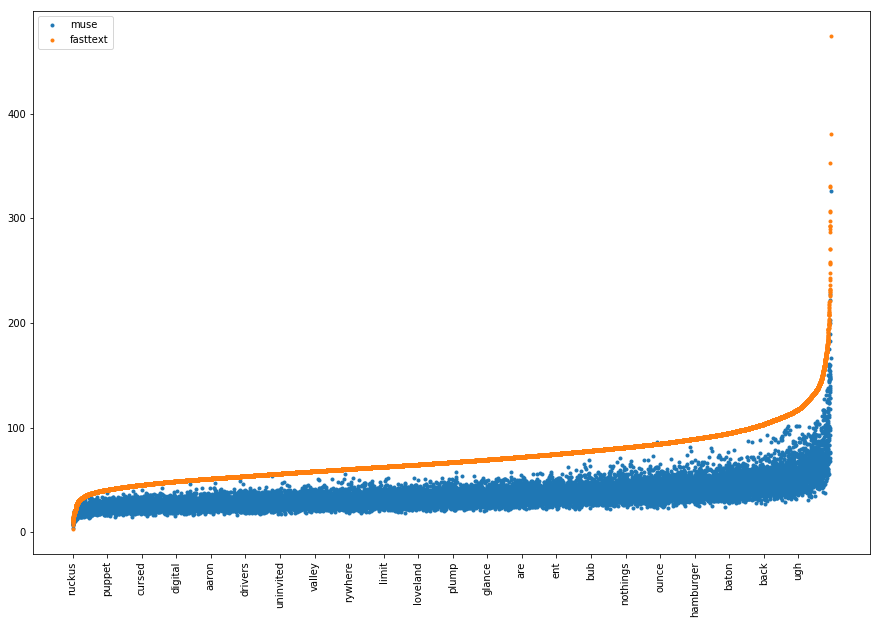

In [66]:
fig = plt.figure(figsize = (15, 10))

x = range(len(ordered_common_words))
plt.scatter(x, ordered_muse_dist, label = "muse", marker = '.')
plt.scatter(x, ordered_fasttext_dist, label = "fasttext", marker = '.')
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
plt.legend()
plt.show()

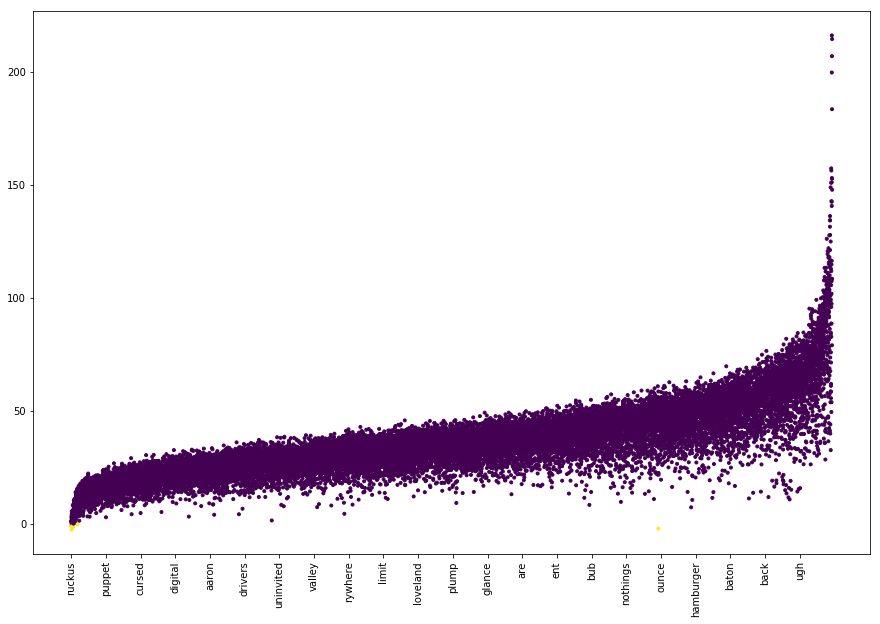

In [67]:
fig = plt.figure(figsize = (15, 10))
dist_diff = ordered_fasttext_dist - ordered_muse_dist
cmap = [ x < 0 for x in dist_diff]
x = range(len(ordered_common_words))

plt.scatter(x, dist_diff, label = "Difference", marker = '.', c = cmap)
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
#plt.hlines(0, 0 , len(ordered_common_words))
plt.show()

Gaussian ( 35.95998969320345 , 15.855410874435677 )


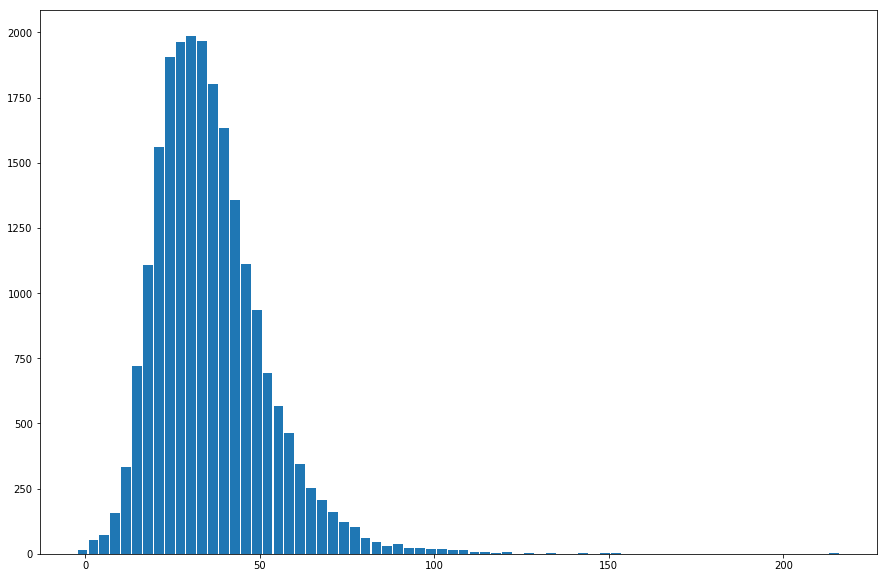

In [68]:
from scipy.stats import norm
import matplotlib.mlab as mlab
# best fit of data
(mu, sigma) = norm.fit(dist_diff)
print("Gaussian (",mu,",", sigma,")")
fig = plt.figure(figsize = (15, 10))
plt.hist(dist_diff, bins=70, rwidth = 0.9)

plt.show()

#### Analysis for distance
- Epoch 100, Refinement 100 : dump = yupm57o3j5, mean_cosine = 0.61315, Gaussian ( 10.9516391597 , 7.31625830261 )
- Epoch 500, Refinement 500 : mean_cosine = 0.76403, dump=slonhca75b, Gaussian ( 35.9599896932 , 15.8554108744 )

## Project

In [75]:
"""words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]

WORDS_TO_SWAP = ordered_terms[:10]

WORDS_TO_SWAP"""

array(['left', 'formed', 'understand', 'things', 'things', 'smile',
       'knowing', 'pick', 'somebody', 'somebody'], dtype='<U10')

In [76]:
from sklearn.neighbors import NearestNeighbors

In [77]:
neigh_pop = NearestNeighbors(n_neighbors=3)
neigh_pop.fit(muse_emb_pop)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [78]:
neigh_rock = NearestNeighbors(n_neighbors=3)
neigh_rock.fit(muse_emb_rock)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [85]:
import pickle

In [86]:
rock_specific = pickle.load( open("rock_specific.p", "rb"))

In [70]:
import random

In [125]:
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'on sleepless nights down in the laundrymat watching the clothes ghosts playing tit for tat we light a joint talk about our old friends dead or alive our stories never end turn it over look on the back page there s johnny gogo looks like he ll never age sits in the park house drinking beer and landing flies just after noon waiting for the trouble boys chorus that s just the way it is here no less and no more severe that s just the way it is here so pull up your socks and lean on your peers did you hear about hank booze rotted out his liver gray and depressed he gave his wife the finger what about his kid what about his exwife ask themselves the same thing when they turn out the lights i still remember the first time i saw him sing 2 black eyes from a knuckle and a biker s ring climbing up the speakers hanging from the balla rafters hamilton punk king swinging to his own disaster chorus pattie couldn t make it she jumped right out the window 3 floors down  cause they cut off her cable d

In [126]:
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)
words_spec_rock

['rotted']

In [127]:
words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

In [128]:
ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]
ordered_terms

array(['exwife', 'pattie', 'laundrymat', 'description', 'balla',
       'rafters', 'heartfelt', 'liver', 'peers', 'jumped', 'rotted',
       'depressed', 'speakers', 'noon', 'sits', 'hank', 'tit', 'tim',
       'hamilton', 'knuckle', 'floors', 'station', 'gogo', 'wing', 'dan',
       'stories', 'sidewalk', 'x2', 'booze', 'playing', 'clothes', 'gray',
       'cause', 'just', 'just', 'just', 'just', 'ball', 'chicken',
       'severe', 'joint', 'flies', 'page', 'lights', 'cable', 'kid',
       'landed', 'street', 'looked', 'socks', 'wife', 'disaster',
       'nights', 'took', 'hear', 'hear', 'story', 'watching', 'park',
       'gas', 'ghosts', 'ask', 'gave', 'looks', 'fiction', 'saw', 'age',
       'ring', 'eyes', 'tat', 'biker', 'climbing', 'pull', 'thing',
       'drinking', 'hanging', 'hanging', 'told', 'couldn', 'cut',
       'window', 'swinging', 'way', 'way', 'lean', 'night', 'fall',
       'chorus', 'chorus', 'chorus', 'friends', 'boys', 'house',
       'remember', 'light', 'make',

In [129]:
SWAP_ROCK = list(set(words_spec_rock))
SWAP_TFIDF = []
i = 0
while len(SWAP_ROCK) + len(SWAP_TFIDF) < 10:
    if ordered_terms[i] not in SWAP_ROCK and ordered_terms[i] not in SWAP_TFIDF:
        SWAP_TFIDF.append(ordered_terms[i])
    i += 1

In [130]:
SWAP_ROCK

['rotted']

In [131]:
SWAP_TFIDF

['exwife',
 'pattie',
 'laundrymat',
 'description',
 'balla',
 'rafters',
 'heartfelt',
 'liver',
 'peers']

In [112]:
def get_nearest_embed(emd, genre):
    if genre == 'pop':
        idx = neigh_pop.kneighbors([emb],return_distance=False)
        return muse_emb_pop[idx][0]
    elif genre == 'rock':
        idx = neigh_rock.kneighbors([emb],return_distance=False)
        return muse_emb_rock[idx][0]

In [113]:
def get_swap_word(w, nb_neighbor, genre):
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, genre)
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    return words[nb_neighbor], words

In [114]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [132]:
swap = {}
for w in SWAP_ROCK:
    new_word, neighbor_words = get_swap_word(w, 0, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

print('-----')
for w in SWAP_TFIDF:
    new_word, neighbor_words = get_swap_word(w, 1, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

rotted -->  ['somesomebody', 'somebodys', 'sombody']
-----
exwife -->  ['somesomebody', 'somebodys', 'sombody']


KeyError: 'pattie'

In [116]:
#Print new lyrics
words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in swap.keys():
        words[i] = color.BOLD + swap[w] + color.END

print(' '.join(words))

i want the kinda credit i just shine it and forget it the somesomebody they all know my name i want the kinda car where my stereo is better the damn things not falling apart i want the kinda hair i can look at and admire not a goofy little ball of flesh i want the kinda life that i can t leave behind i ll be a little ray of sunshine but ohwho cares gimme a beer i want the kinda girl she can dance she can twirl going out at night with her friends i want the kinda dog that listens when i call and somesomebody on my neighbors fence i want the kinda clothes so everybody knows here comes a confident man i want the kinda smile that radiates for miles man i cause a trafic jam but ohwho cares gimme a beer gimme a beer gimme a beer i want the kinda watch so everyone will talk and say hey his is better than mine i want the kinda chains golden and somesomebody don t look man you might go blind i want the kinda feline like a tiger or a lion and listen to my baby purr i want the kina house i ll sit

In [80]:
swap = {}
for w in WORDS_TO_SWAP:
    #Read original embedding
    """idx = vocabulary_rock.index(w)
    emb = word_embeddings_rock[idx]
    print(w, emb)"""
    #Read mapped embedding
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, 'pop')
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    swap[w] = words
    print(w,' --> ',swap[w])

left  -->  ['left', 'cleft', 'leftover']
formed  -->  ['formed', 'recycled', 'entitled']
understand  -->  ['understand', 'misunderstand', 'understandable']
things  -->  ['things', 'somethings', 'everythings']
things  -->  ['things', 'somethings', 'everythings']
smile  -->  ['smile', 'smiley', 'smirk']
knowing  -->  ['knowing', 'doubting', 'compromising']
pick  -->  ['pick', 'pickney', 'pickup']
somebody  -->  ['somesomebody', 'somebodys', 'sombody']
somebody  -->  ['somesomebody', 'somebodys', 'sombody']


In [81]:
#Print new lyrics
"""words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in WORDS_TO_SWAP:
        words[i] = swap[w]

words"""

['i',
 'can',
 't',
 'be',
 'myself',
 'when',
 'i',
 'm',
 'alone',
 'i',
 'think',
 'stupid',
 ['things', 'somethings', 'everythings'],
 'when',
 ['left', 'cleft', 'leftover'],
 'on',
 'my',
 'own',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 'be',
 'around',
 'someone',
 'to',
 'play',
 'up',
 'to',
 'to',
 'fool',
 'about',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 ['pick', 'pickney', 'pickup'],
 'me',
 'up',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'oh',
 'anybody',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'you',
 'know',
 'that',
 'it',
 's',
 'you',
 'i',
 'think',
 'out',
 'loud',
 'when',
 'there',
 's',
 'noone',
 'around',
 'i',
 'can',
 't',
 ['understand', 'misunderstand', 'understandable'],
 'why',
 'i',
 'ever',
 'get',
 'down',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 'take',
 'me',
 'home',
 'to',
 'the',
 'world',
 'i',
 'once',
 'knew',
 'was',
 ['formed', 'recy

### Partial MUSE

## Goal of notebook 
- Create word model for pop and rock
- Compute embeddings for words in pop and rock
- Apply MUSE matching

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
filepath = "lyrics_final_clean.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.dropna(axis = 0, how='any', subset=['lyrics'])
lyrics_df.head()

,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0


In [3]:
import sys
import codecs

In [4]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [5]:
word_embeddings_pop, vocabulary_pop = load_embeddings('cbow_model_lyrics_pop.vec')

In [6]:
word_embeddings_rock, vocabulary_rock = load_embeddings('cbow_model_lyrics_rock.vec')

In [7]:
voc_pop = list(vocabulary_pop)
voc_rock = list(vocabulary_rock)

In [8]:
len(voc_rock)

33988

In [9]:
print(len(voc_pop))

29542


In [10]:
common_words = set(voc_pop).intersection(set(voc_rock))
print(len(common_words))
common_words = list(common_words)

21950


In [13]:
pop_specific = set(voc_pop).difference(set(common_words))
rock_specific = list(set(voc_rock).difference(set(common_words)))

In [14]:
print(len(pop_specific))
print(len(rock_specific))

7592
12038


In [15]:
#Percentage of common words 
print(len(common_words)/len(voc_pop))
print(len(common_words)/len(voc_rock))

0.7430099519328414
0.6458161704130869


In [14]:
import copy
def get_partial_vocabularies(perc):
    nb_to_remove = int(np.round((1-perc)*len(common_words)))
    print("Number of common words removed : ", nb_to_remove)
    selected_common_words = random.sample(common_words, nb_to_remove)
    selected_pop_voc = list(copy.deepcopy(vocabulary_pop))
    selected_rock_voc = list(copy.deepcopy(vocabulary_rock))
    selected_pop_embed = list(copy.deepcopy(word_embeddings_pop))
    selected_rock_embed = list(copy.deepcopy(word_embeddings_rock))
    for w in selected_common_words:
        idx_pop = vocabulary_pop.index(w)
        idx_rock = vocabulary_rock.index(w)
        selected_pop_voc[idx_pop] = 'NaN'
        selected_pop_embed[idx_pop] = 'NaN'
        selected_rock_voc[idx_rock] = 'NaN'
        selected_rock_embed[idx_rock] = 'NaN'
    
    selected_pop_voc = list(filter(lambda x: x != 'NaN', selected_pop_voc))
    selected_pop_embed = list(filter(lambda x: x != 'NaN', selected_pop_embed))
    selected_rock_voc = list(filter(lambda x: x != 'NaN', selected_rock_voc))
    selected_rock_embed = list(filter(lambda x: x != 'NaN', selected_rock_embed))
    """print(len(word_embeddings_pop))
    print(len(selected_pop_embed)+ nb_to_remove)
    print(len(word_embeddings_rock))
    print(len(selected_rock_embed)+ nb_to_remove)"""
    #print(len(selected_pop_voc) == len(selected_pop_embed))
    
    return selected_pop_voc, selected_pop_embed, selected_rock_voc, selected_rock_embed

In [15]:
pop_voc_75, pop_embed_75, rock_voc_75, rock_embed_75 = get_partial_vocabularies(0.75)

Number of common words removed :  5488


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [174]:
pop_voc_50, pop_embed_50, rock_voc_50, rock_embed_50 = get_partial_vocabularies(0.5)

Number of common words removed :  10975


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [175]:
pop_voc_25, pop_embed_25, rock_voc_25, rock_embed_25 = get_partial_vocabularies(0.25)

Number of common words removed :  16462


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [189]:
print(round(pop_embed_75[0][0], 7))

2.5513


In [193]:
str_ = ''
for x in pop_embed_75[0]:
    str_ = str_ + str(round(x,7)) +' '
    
str_

'2.5513 -0.67314 -2.6041 -0.65499 2.5479 1.1821 0.94551 1.9132 -0.03946 1.3754 0.34791 1.3157 -0.76442 1.7082 0.5161 -0.81964 1.1613 -0.18665 -0.94979 -0.41297 -1.5338 0.19622 -0.2695 -1.263 1.0004 -0.24717 1.9912 -0.52688 0.4605 0.27812 -0.20491 -1.0826 -0.30503 0.58974 -2.053 0.20593 0.84472 0.25543 -1.0134 1.3927 -1.0817 0.63854 0.26633 4.2355 0.73335 -0.57185 1.0761 0.84098 -1.0181 2.7724 0.99602 0.99885 -1.8186 -1.3611 1.4948 0.26265 -0.33812 0.33232 -1.3647 0.51959 0.80607 0.19404 -0.049289 1.025 -0.78717 1.1622 -0.45162 -1.0891 -1.4351 0.42565 -0.087215 1.8192 1.2125 1.224 0.78866 -1.3284 -0.64849 -1.6629 0.87404 -0.1511 0.70841 -3.5287 0.11822 -1.3758 0.0026896 -1.2074 0.53309 1.9728 1.0147 0.71674 -1.1662 0.67856 -0.15674 0.36633 0.42427 -0.0045239 -0.011005 -0.91143 -2.1724 0.52828 '

In [198]:
def create_vec_file(file_name, voc, embed):
    with codecs.open(file_name, 'w', 'utf-8') as f:
        f.write(str(len(voc))+' 100\n')
        for i,w in enumerate(voc):
            l = w + ' '
            for x in embed[i]:
                l = l + str(round(x,7)) + ' '
            l = l + '\n'
            f.write(l)

In [199]:
create_vec_file('cbow_model_lyrics_pop_75.vec', pop_voc_75, pop_embed_75)

In [200]:
create_vec_file('cbow_model_lyrics_rock_75.vec', rock_voc_75, rock_embed_75)

In [254]:
create_vec_file('cbow_model_lyrics_pop_50.vec', pop_voc_50, pop_embed_50)
create_vec_file('cbow_model_lyrics_pop_25.vec', pop_voc_25, pop_embed_25)
create_vec_file('cbow_model_lyrics_rock_50.vec', rock_voc_50, rock_embed_50)
create_vec_file('cbow_model_lyrics_rock_25.vec', rock_voc_25, rock_embed_25)

## TF-IDF
Source : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
corpus_pop = list(lyrics_df[lyrics_df['genre'] == 'pop']['lyrics'])
corpus_pop = [x.replace('\n', ' ') for x in corpus_pop]

In [18]:
corpus_rock = list(lyrics_df[lyrics_df['genre'] == 'rock']['lyrics'])
corpus_rock = [x.replace('\n', ' ') for x in corpus_rock]

In [19]:
def get_tfidf(corpus, max_freq, min_freq):
    tf = TfidfVectorizer(stop_words='english', max_df=max_freq, min_df=min_freq)
    X = tf.fit(corpus)
    X_transformed = X.transform(corpus)
    # find maximum value for each of the features over all of dataset:
    max_val = X_transformed.max(axis=0).toarray().ravel()

    feature_names = np.array(tf.get_feature_names())
    sorted_by_idf = np.argsort(tf.idf_)

    #sort weights from smallest to biggest and extract their indices 
    sort_by_tfidf = max_val.argsort()
    return feature_names[sort_by_tfidf]

In [20]:
tfidf_pop = get_tfidf(corpus_pop, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_pop[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_pop[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['youven' 'gakka' 'kkeuteopneun' 'sorijilleobwa' 'wabwa' 'jeulgyeobwa'
 'urimodu' 'isunganeun' '2pm' 'jjaritan']

Features with highest tfidf: 
['turn' 'understanding' 'stingray' 'lyrics' 'dark' 'hey' 'intrumental'
 'embed' 'coming' 'silhouette']


In [21]:
tfidf_rock = get_tfidf(corpus_rock, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_rock[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_rock[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['aalley' 'heighho' 'greivin' 'yeshot' 'yayara' 'saftey' 'chinchara'
 'acelandine' 'hivoltage' 'spik']

Features with highest tfidf: 
['nazareth' 'paid' 'aumgn' 'say' 'special' 'awolnation' 'fm' 'paranoid'
 'raining' 'want']


## MUSE
- Supervised: using a train bilingual dictionary (or identical character strings as anchor points), learn a mapping from the source to the target space using (iterative) Procrustes alignment.
- Unsupervised: without any parallel data or anchor point, learn a mapping from the source to the target space using adversarial training and (iterative) Procrustes refinement.

In [61]:
N_EPOCH = 50
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 50
CHOSEN_EMBEDDING = 'cbow_'#'skipgram_'
CHOSEN_PERC = str(75)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' #'cbow_model_lyrics_rock_' + CHOSEN_PERC +'.vec'
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' #CHOSEN_EMBEDDING +'model_lyrics_pop.vec'
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC

In [99]:
def analyse_run(data):
    data = ' '.join(data)
    dump = data.split('exp_path: /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/')[1].split(' ')[0]
    substring = data.split('* Best value for "mean_cosine-csls_knn_10-S2T-10000": ')[-1]
    iteration = substring.split('End of ')[1].split('. ')[0]
    best_mean_cosine = substring.split(' INFO')[0]
    print("For dump ", dump, " the best mean cosine was ", best_mean_cosine, " reached at ", iteration)

In [115]:
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  wnckibdcl1  the best mean cosine was  0.61150  reached at  refinement iteration 49


In [101]:
CHOSEN_PERC = str(50)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' 
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' 
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  7r6qvrluj7  the best mean cosine was  0.60310  reached at  refinement iteration 49


In [100]:
CHOSEN_PERC = str(25)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' 
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' 
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  ey4p6vloxi  the best mean cosine was  0.61772  reached at  refinement iteration 49


#### Note performance : 
Use CBOW
- 75% : 
    - Epoch 50, Refinement 50 : For dump  ylwj8ubtdw  the best mean cosine was  0.61142  reached at  refinement iteration 43

- 50% : 
    - Epoch 50, Refinement 50 : For dump  d8jnijiuxu  the best mean cosine was  0.62547  reached at  refinement iteration 49
    
- 25% :
    - Epoch 50, Refinement 50 : For dump  j9tzccphji  the best mean cosine was  0.63224  reached at  refinement iteration 49

Alternative : Partial Rock, Full Pop
- 75% : 
    - Epoch 50, Refinement 50 : For dump  858vfrdtoz  the best mean cosine was  0.62030  reached at  refinement iteration 49

- 50% : 
    - Epoch 50, Refinement 50 : For dump  3pui0lkb3b  the best mean cosine was  0.62266  reached at  refinement iteration 44
    
- 25% :
    - Epoch 50, Refinement 50 : For dump  co8l8h7b4g  the best mean cosine was  0.64415  reached at  refinement iteration 48
    
Not correct, needs to be the otherway round : Full Rock and partial pop:
- 75% : 
    - Epoch 50, Refinement 50 : For dump  wnckibdcl1  the best mean cosine was  0.61150  reached at  refinement iteration 49
    - Epoch 50, Refinement 50 : For dump  zf6o2u6vhb  the best mean cosine was  0.61022  reached at  refinement iteration 44
    - Epoch 50, Refinement 50 : For dump  aw0a6ud2ts  the best mean cosine was  0.61131  reached at  refinement iteration 49
- 50% : 
    - Epoch 50, Refinement 50 : For dump pky4gwq3eg the best mean cosine was 0.60795 reached at refinement iteration 48
- 25% : 
    - Epoch 50, Refinement 50 : For dump  ey4p6vloxi  the best mean cosine was  0.61772  reached at  refinement iteration 49

## Project

In [111]:
import pickle

In [112]:
pickle.dump(rock_specific ,open( "rock_specific.p", "wb" ))

In [88]:
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'turn sweet as salt we burn with lightning fury in sudden squall we drift in solitary lines i ll follow you through walls of sleepless currents the way that towers over us betrays tomorrow tell me again tell me again how it turns out after the sun and the stars stop burning after the wars will the world keep revolving after the storms will we come out shining like rubies like rubies i ll stay with you until the story s over till winter blooms into summer and we drown in wordless beauty tell me again tell me again how it goes down hold me again hold me again pull me closer'

In [89]:
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)
words_spec_rock

['squall', 'wordless']

In [113]:
pickle.dump(tfidf_rock,open("tfidf_rock.p", "wb"))

In [90]:
words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

In [91]:
ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]

In [92]:
ordered_terms

array(['wordless', 'towers', 'rubies', 'rubies', 'storms', 'squall',
       'revolving', 'betrays', 'drift', 'currents', 'lines', 'solitary',
       'blooms', 'winter', 'salt', 'fury', 'lightning', 'stars', 'wars',
       'story', 'shining', 'sweet', 'walls', 'tomorrow', 'summer', 'pull',
       'sun', 'sudden', 'way', 'drown', 'till', 'beauty', 'come', 'stay',
       'burning', 'sleepless', 'world', 'turns', 'stop', 'll', 'll',
       'tell', 'tell', 'tell', 'tell', 'turn', 'closer', 'goes', 'like',
       'like', 'follow', 'burn', 'hold', 'hold'], dtype='<U9')

In [93]:
SWAP_ROCK = list(set(words_spec_rock))
SWAP_TFIDF = []
i = 0
while len(SWAP_ROCK) + len(SWAP_TFIDF) < 10:
    if ordered_terms[i] not in SWAP_ROCK and ordered_terms[i] not in SWAP_TFIDF:
        SWAP_TFIDF.append(ordered_terms[i])
    i += 1

In [94]:
SWAP_ROCK

['squall', 'wordless']

In [95]:
SWAP_TFIDF

['towers',
 'rubies',
 'storms',
 'revolving',
 'betrays',
 'drift',
 'currents',
 'lines']

In [74]:
muse_emb_rock = "vectors-" + CHOSEN_EMBEDDING + "rock_" + CHOSEN_PERC+ ".txt"
muse_emb_pop = "vectors-" + CHOSEN_EMBEDDING + "pop_" + CHOSEN_PERC +".txt"

In [76]:
muse_emb_rock, muse_voc_rock = load_embeddings(muse_emb_rock)

In [77]:
muse_emb_pop, muse_voc_pop = load_embeddings(muse_emb_pop)

In [49]:
def get_dict(embed, voc):
    voc_embeds_dict = {}
    embeds_voc_dict = {}

    for v, emb in zip(voc, embed):
        voc_embeds_dict[v] = tuple(emb)
        embeds_voc_dict[tuple(emb)] = v
    return voc_embeds_dict, embeds_voc_dict

In [78]:
word_embeddings_pop, vocabulary_pop = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_pop_'+ CHOSEN_PERC+ '.vec')
word_embeddings_rock, vocabulary_rock = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_rock_'+ CHOSEN_PERC+ '.vec')

In [79]:
voc2embed_rock, embed2voc_rock = get_dict(word_embeddings_rock, vocabulary_rock)
voc2embed_pop, embed2voc_pop = get_dict(word_embeddings_pop, vocabulary_pop)

In [77]:
def see_movement(w):
    print("Movement in rock : ")
    print(sum(abs(np.array(muse_voc2embed_rock[w]) - voc2embed_rock[w])))
    print("Distance in fastext between 2 words : ")
    print(sum(abs(np.array(voc2embed_rock[w])- voc2embed_pop[w])))
    print("Distance in muse between 2 words : ")
    print(sum(abs(np.array(muse_voc2embed_rock[w])- muse_voc2embed_pop[w])))

In [80]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

In [ ]:
see_movement('you')

In [54]:
from sklearn.neighbors import NearestNeighbors

In [81]:
neigh_pop = NearestNeighbors(n_neighbors=3)
neigh_pop.fit(muse_emb_pop)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [82]:
neigh_rock = NearestNeighbors(n_neighbors=3)
neigh_rock.fit(muse_emb_rock)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [57]:
def get_nearest_embed(emb, genre):
    if genre == 'pop':
        idx = neigh_pop.kneighbors([emb],return_distance=False)
        return muse_emb_pop[idx][0]
    elif genre == 'rock':
        idx = neigh_rock.kneighbors([emb],return_distance=False)
        return muse_emb_rock[idx][0]

In [70]:
def get_swap_word(w, nb_neighbor, genre):
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, genre)
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    return words[nb_neighbor], words

In [71]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [96]:
swap = {}
for w in SWAP_ROCK:
    new_word, neighbor_words = get_swap_word(w, 0, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

print('-----')
for w in SWAP_TFIDF:
    new_word, neighbor_words = get_swap_word(w, 1, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

squall -->  ['syncopate', 'funktafied', 'foxtrot']
wordless -->  ['sympathizing', 'selfdeceiving', 'insincerity']
-----
towers -->  ['feathered', 'tethered', 'watercolored']
rubies -->  ['orchids', 'dvds', 'soaps']
storms -->  ['tethered', 'enlightened', 'burdened']
revolving -->  ['nursing', 'insulting', 'erupting']
betrays -->  ['furthermore', 'sympathizing', 'sojourn']
drift -->  ['explored', 'unfazed', 'enclose']
currents -->  ['disgruntled', 'fossils', 'caverns']
lines -->  ['grownups', 'grownup', 'worshiped']


In [97]:
#Print new lyrics
words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in swap.keys():
        words[i] = color.BOLD + swap[w] + color.END

print(' '.join(words))

turn sweet as salt we burn with lightning fury in sudden syncopate we unfazed in solitary grownup i ll follow you through walls of sleepless fossils the way that tethered over us sympathizing tomorrow tell me again tell me again how it turns out after the sun and the stars stop burning after the wars will the world keep insulting after the enlightened will we come out shining like dvds like dvds i ll stay with you until the story s over till winter blooms into summer and we drown in sympathizing beauty tell me again tell me again how it goes down hold me again hold me again pull me closer


[Go to top](#top)

<a id="nn"></a>

## Neural Network

[Go to top](#top)

<a id="site"></a>

## Webpage

- Mettre lien vers les fichiers nécessaires
- Commande à lancer
- Screenshots

[Go to top](#top)